In [1]:
from __future__ import print_function
import os,sys
import pandas as pd
import numpy as np
import datetime as dt
import pickle
from glob import glob


In [2]:
os.getcwd()

'C:\\Users\\kesj\\Documents\\IPython Notebooks\\otherSFprojects\\HRsepara'

In [3]:
os.chdir('../../../projects/HRattrition/reduced/')

In [5]:
os.chdir('../survival/')
%ls

 Volume in drive C is OS
 Volume Serial Number is 222B-1C6E

 Directory of C:\Users\kesj\Documents\projects\HRattrition\survival

03/11/2016  09:30 AM    <DIR>          .
03/11/2016  09:30 AM    <DIR>          ..
02/15/2016  02:17 PM        80,315,848 after2001_v8.csv
03/11/2016  09:48 AM        41,364,624 current_v8.ssv
02/16/2016  04:39 PM            38,162 forecasted_survival_withCI.png
02/18/2016  04:32 PM            21,556 ne2e_surv_probabilitydistrib_five_year.png
02/18/2016  04:28 PM            12,327 p5_surv_ne2e_confusion.png
02/15/2016  01:54 PM        44,424,785 separation_cf4.pkl
               6 File(s)    166,177,302 bytes
               2 Dir(s)  84,293,062,656 bytes free


In [9]:
empl = pd.read_csv('current_v8.ssv',sep=';',dtype={'KEY':np.str})
empl.shape

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(69475, 126)

In [10]:
empl.head()

,ADDRCNT1,ADDRCNT10,ADDRCNT3,ADDRCNT5,ANNUAL_RT,Age_tdelta,Age_years,BIRTHDATE,BOX1,COMPANY,...,HAVE_DEP,DEP_COUNT,sep_status,mar_status,retired,terminated,hire_tstmp,term_tstmp,birth_tstmp,hire_age
0,1,1,1,1,16099.20,7788 days 00:00:00.000000000,21.322820,1993-09-05,0,1,...,0,0,0,1,0,0,2014-06-09,2015-01-01,1993-09-05,20.758811
1,0,1,1,1,31045.35,9808 days 00:00:00.000000000,26.853392,1988-02-24,2,1,...,0,0,0,1,0,0,2012-12-10,2015-01-01,1988-02-24,24.794486
2,0,1,1,1,39882.98,8665 days 00:00:00.000000000,23.723964,1991-04-12,2,1,...,0,0,0,1,0,0,2012-06-04,2015-01-01,1991-04-12,21.147594
3,0,0,0,0,44694.03,21052 days 00:00:00.000000000,57.638418,1957-05-13,2,5,...,1,1,0,0,0,0,1975-09-02,2015-01-01,1957-05-13,18.305646
4,0,0,0,0,78093.34,17164 days 00:00:00.000000000,46.993436,1968-01-04,2,5,...,1,3,0,0,0,0,1994-12-05,2015-01-01,1968-01-04,26.919102


## load the employee file (converted)

In [4]:
empl = pd.read_csv('after2001_v3.csv',dtype={'EMPL_CLASS':np.str,'EEO1CODE':np.str,'KEY':np.str})
empl.shape

(134266, 69)

## load the 'sample text file'

In [5]:
#os.chdir('../webserverTest/testdata/')


In [8]:
os.chdir('../')

In [18]:
def parse_input_file(my_path,delimiter_char=";",cols=None):
    if my_path[-1] != '/':
        my_path+='/'

    
    infile = glob(my_path+'*.*')[0]
    #try:
    print (infile)
    if cols != None:
        employee_df = pd.read_csv(infile, sep=delimiter_char,dtype={'KEY':np.str},usecols=cols)
    else:
        employee_df = pd.read_csv(infile, sep=delimiter_char,dtype={'KEY':np.str})
    
    return employee_df

In [17]:
edf = parse_input_file('uploads')

uploads\tset3.ssv


In [21]:
edf.shape

(10, 118)

In [25]:
[c for c in edf.columns.tolist() if c.endswith('years')]

[]

## get the model parsing working

In [26]:
MODEL_BASE_PATH = u'C:/Users/kesj/Documents/projects/HRattrition/webserverTest/models/'


In [37]:
def find_survival_models(MDL_BASE_PATH):#,pkl_name,pred_years):
    surv_pkl_files = glob(MDL_BASE_PATH+'*.pkl')
    # n_files =len(surv_pkl_files)
    # if n_files <2:
    #     print("Sorry but less than 2 models were found. Recheck the path %s and try again" % MDL_BASE_PATH)
    # elif n_files > 2:
    #     print("the last model of each type will be used")
    prediction_cases = ['sep', 'ret']

    mdl_files = []
    mdl_files.append([a for a in surv_pkl_files if prediction_cases[0] in a][-1])
    mdl_files.append([a for a in surv_pkl_files if prediction_cases[1] in a][-1])
    
    return mdl_files

def get_surv_columns(surv_mdl):
    """
    Function to parse the given model and identify list of columns needed for input.
    input: surv_mdl = a survival model
    output: a list of columns required by this model.
    """
    #event_col = surv_mdl.event_observed.name
    time_col = surv_mdl.durations.name
    model_cols = surv_mdl.hazards_.columns.tolist()
    cols_to_keep = [a for a in model_cols]
    #cols_to_keep.append(event_col)
    cols_to_keep.append(time_col)
    return cols_to_keep


In [28]:
mdl_files = find_survival_models(MODEL_BASE_PATH)
mdl_files

[u'C:/Users/kesj/Documents/projects/HRattrition/webserverTest/models\\separation_cf4.pkl',
 u'C:/Users/kesj/Documents/projects/HRattrition/webserverTest/models\\retirement_sf2.pkl']

In [38]:
sep_mdl = pickle.load(open(mdl_files[0],'rb'))
sep_cols = get_surv_columns(sep_mdl)
print(sep_cols)

['Age_years', 'SAL1', 'MERIT1', 'PERF1', 'BOX1', 'SEX', 'HAVE_INS', 'HAVE_DEP', 'DEPTCNT1', 'EXTFUNC_CNT', 'FUNC_CNT', 'REMOTE', 'DIRECT_RPT_CNT', 'HUBIND', 'REH_CNT', 'JOB_FUNCTION_PSA', 'Tenure_years']


In [39]:
ret_mdl = pickle.load(open(mdl_files[1],'rb'))
ret_cols = get_surv_columns(ret_mdl)
print(ret_cols)

['Age_years', 'SAL1', 'MERIT1', 'PERF1', 'BOX1', 'SEX', 'HAVE_INS', 'HAVE_DEP', 'Tenure_years']


In [33]:
df_cols = edf.columns.tolist()


## identify columns that need to be constructed

In [40]:
cols_to_construct = list(set(sep_cols)-set(df_cols))
print(cols_to_construct)

['JOB_FUNCTION_PSA', 'Tenure_years', 'Age_years']


In [41]:
list(set(ret_cols)-set(df_cols))

['Tenure_years', 'Age_years']

In [56]:
def calculate_years(timestamp1,timestamp2,days_in_year =365.25):
    number_of_years = (timestamp2 - timestamp1).days/days_in_year
    return number_of_years

In [57]:
sep_cols_to_construct = list(set(sep_cols)-set(df_cols))
ret_cols_to_construct = list(set(ret_cols)-set(df_cols))
## assume the time column(s) are in years
time_cols = [col for col in sep_cols_to_construct if col.endswith('years')]
if time_cols != []:
    # 1. calculate Age and tenure from dates provided:
    #    * convert  HIRE_DT, BIRTHDATE and current_time to timestamps
    # 2. use these as years
    edf[['hire_tstmp','birth_tstmp']] = edf[['HIRE_DT','BIRTHDATE']]\
        .applymap(lambda x: pd.to_datetime(dt.datetime.strptime(x,'%d%b%Y')))
    edf[['Age_years','Tenure_years']] = edf[['birth_tstmp','hire_tstmp']]\
        .applymap(lambda x: calculate_years(x, today_timestamp))
    #hire_age_tdelta = employee_df['hire_tstmp']-employee_df['birth_tstmp']
    # convert to days, months, or years
    #employee_df['hire_age'] = hire_age_tdelta/np.timedelta64(1,'Y')

for tcol in time_cols:
    sep_cols_to_construct.remove(tcol)
    ret_cols_to_construct.remove(tcol)

In [59]:
sep_cols_to_construct, ret_cols_to_construct

(['JOB_FUNCTION_PSA'], [])

## deal with missing cols

In [61]:
for col in ret_cols_to_construct:
    print (col)

In [70]:
edf['JOBB_NFW']=edf['JOB_FUNCTION'].apply(lambda x: 1 if x=='NFW' else 0)

In [66]:
for col in sep_cols_to_construct:
    pieces = col.split('_')
    print(len(pieces))
    dummy_cat = pieces[-1]
    main_cat = "_".join(piece for piece in pieces[:-1])
    print(main_cat,dummy_cat)
    edf[col]=edf[main_cat].apply(lambda x: 1 if x==dummy_cat else 0)

3
JOB_FUNCTION PSA


In [68]:
edf.JOB_FUNCTION_PSA.sum()

5L

In [49]:
pd.to_datetime(dt.datetime(2015,1,1))

Timestamp('2015-01-01 00:00:00')

In [46]:
today_timestamp = pd.to_datetime(dt.datetime.today())
print(today_timestamp)

2016-03-07 13:10:50.323000


In [90]:
col_to_omit = ['JOBB']

In [92]:
sep_cols = list(set(sep_cols)-set(col_to_omit))
sep_cols

['REH_CNT',
 'REMOTE',
 'MERIT1',
 'Age_years',
 'EXTFUNC_CNT',
 'PERF1',
 'FUNC_CNT',
 'SEX',
 'HAVE_DEP',
 'DIRECT_RPT_CNT',
 'HAVE_INS',
 'HUBIND',
 'DEPTCNT1',
 'JOB_FUNCTION_PSA',
 'Tenure_years',
 'BOX1',
 'SAL1']

In [87]:
try: 
    sep_cols.remove(m_col)
#except ValueError:
#    pass



SyntaxError: invalid syntax (<ipython-input-87-a864721378f6>, line 5)

In [85]:
if len(m_col):
    sep_cols.remove(m_col)
    try:
        sep_cols.remove(m_col)        

IndentationError: unexpected unindent (<ipython-input-85-cfe69ffab4b9>, line 4)

In [86]:
if len(m_col):
    sep_cols.remove(m_col)
    try:
        sep_cols.remove(m_col)

IndentationError: unexpected unindent (<ipython-input-86-335051e0d745>, line 4)

In [93]:
sdf = edf[sep_cols].copy()
sdf.isnull().any()

REH_CNT             False
REMOTE              False
MERIT1              False
Age_years           False
EXTFUNC_CNT         False
PERF1               False
FUNC_CNT            False
SEX                 False
HAVE_DEP            False
DIRECT_RPT_CNT      False
HAVE_INS            False
HUBIND              False
DEPTCNT1            False
JOB_FUNCTION_PSA    False
Tenure_years        False
BOX1                 True
SAL1                False
dtype: bool

In [119]:
column_type = {}
cols_to_convert =[]
for c in sdf.columns.tolist():
    my_dtype = sdf[c].dtype.kind
    print(c,sum(sdf[c].isnull()),my_dtype)
    column_type[c]=my_dtype
    if my_dtype not in 'biufc':
        cols_to_convert.append(c)
print(cols_to_convert)

REH_CNT 0 i
REMOTE 0 O
MERIT1 0 f
Age_years 0 f
EXTFUNC_CNT 0 i
PERF1 0 f
FUNC_CNT 0 i
SEX 0 O
HAVE_DEP 0 O
DIRECT_RPT_CNT 0 i
HAVE_INS 0 O
HUBIND 0 O
DEPTCNT1 0 i
JOB_FUNCTION_PSA 0 i
Tenure_years 0 f
BOX1 1 O
SAL1 0 f
['REMOTE', 'SEX', 'HAVE_DEP', 'HAVE_INS', 'HUBIND', 'BOX1']


In [126]:

sdf[cols_to_convert].isnull().any().index

Index([u'REMOTE', u'SEX', u'HAVE_DEP', u'HAVE_INS', u'HUBIND', u'BOX1'], dtype='object')

In [120]:
edf[cols_to_convert].head()

,REMOTE,SEX,HAVE_DEP,HAVE_INS,HUBIND,BOX1
0,N,M,N,Y,N,S
1,Y,F,Y,Y,Y,H
2,N,F,Y,Y,N,S
3,N,F,Y,Y,Y,H
4,N,M,N,Y,Y,S


In [127]:
sdf.columns[sdf[sep_cols].dtypes=="object"].tolist()

['REMOTE', 'SEX', 'HAVE_DEP', 'HAVE_INS', 'HUBIND', 'BOX1']

In [128]:
mask = np.array(sdf[cols_to_convert].count()<len(sdf))
list(np.array(cols_to_convert)[mask])

['BOX1']

In [129]:
nn_missing_cols = list(np.array(cols_to_convert)[mask])
for col in nn_missing_cols:
    sdf[col].fillna(-1,inplace=True)
    
sdf.isnull().any()

REH_CNT             False
REMOTE              False
MERIT1              False
Age_years           False
EXTFUNC_CNT         False
PERF1               False
FUNC_CNT            False
SEX                 False
HAVE_DEP            False
DIRECT_RPT_CNT      False
HAVE_INS            False
HUBIND              False
DEPTCNT1            False
JOB_FUNCTION_PSA    False
Tenure_years        False
BOX1                False
SAL1                False
dtype: bool

In [144]:
tdata = pd.DataFrame(data = [[-1,np.nan, 3, 11],[11,2, 5, 13],[4,3.5,np.nan,4]],columns=['mine','yours','ours','theirs'])
tdata

,mine,yours,ours,theirs
0,-1,NaN,3,11
1,11,2.0,5,13
2,4,3.5,NaN,4


In [145]:
n_mask = np.array(tdata.count() < len(tdata))
n_missing_cols = list(np.array(tdata.columns.tolist())[n_mask])
n_missing_cols

['yours', 'ours']

In [146]:
for c in n_missing_cols:
    min_val = tdata[c].min()
    print(c,min_val)

yours 2.0
ours 3.0


In [136]:
sdf.BOX1.min()

-1

In [130]:
cols_to_convert

['REMOTE', 'SEX', 'HAVE_DEP', 'HAVE_INS', 'HUBIND', 'BOX1']

In [132]:
[(col,sdf[col].nunique()) for col in cols_to_convert]

[('REMOTE', 2),
 ('SEX', 2),
 ('HAVE_DEP', 2),
 ('HAVE_INS', 1),
 ('HUBIND', 2),
 ('BOX1', 3)]

In [138]:
indicator_dict = {'INTERN': {'N':0,'Y':1},
                  'REMOTE': {'N':0,'Y':1}, 'FULLPART1': {'N':0,'Y':1},
                 'RELOCATE_ALL_SFI' : {'N':0,'Y':1},
                'HUBIND':{'N':0,'Y':1},'SUPV_DIFF_LOC':{'N':0,'Y':1},
     'HAVE_DEP': {'N':0,'Y':1},'HAVE_INS':{'N':0,'Y':1},'PARTFULL1':{'N':0,'Y':1},
    'REMOTE_SUPV':{'N':0,'Y':1}, 'COMP_FREQUENCY': {'A':1,'H':0}, 
                  'SEX': {'M':1,'F':0},'BOX1':{'H':3,'S':2,'L':1},'SHIFT':{'N':0,'1':1,'2':2,'3':3}}
for key,value in indicator_dict.iteritems():
    if key in cols_to_convert:
        sdf[key].replace(value,inplace=True)

In [139]:
sdf[cols_to_convert].replace({'N':0},{'Y':1}, inplace=True)

In [140]:
sdf.HAVE_INS.value_counts()

1    10
Name: HAVE_INS, dtype: int64

## check that all are now numeric

In [143]:
if (sdf.dtypes[sdf.dtypes.apply(lambda x: str(x).startswith(("float", "int", "bool")))].index.tolist() != sep_cols):
    print("ERROR")


In [190]:
def prep_data(df, sep_cols, ret_cols, today_timestamp):
    """

    :param df:
    :param cols_to_keep:
    :param today_timestamp:
    :return: tmp_df, sep_cols, ret_cols
    """
    # identify columns that need processing
    input_cols = df.columns.tolist()

    cols_to_model = list(set(sep_cols).union(set(ret_cols)))
    cols_to_construct = list(set(cols_to_model)-set(input_cols))
    cols_to_keep = list(set(cols_to_model).union(set(input_cols)))



    # assume the time column(s) are in years
    time_cols = [col for col in cols_to_construct if col.endswith('years')]
    if len(time_cols): # if length is zero this is skipped
        # 1. calculate Age and tenure from dates provided:
        #    * convert  HIRE_DT, BIRTHDATE and current_time to timestamps
        # 2. use these as years
        df[['hire_tstmp','birth_tstmp']] = df[['HIRE_DT','BIRTHDATE']]\
            .applymap(lambda x: pd.to_datetime(dt.datetime.strptime(x,'%d%b%Y')))
        df[['Age_years','Tenure_years']] = df[['birth_tstmp','hire_tstmp']]\
            .applymap(lambda x: calculate_years(x, today_timestamp))
        #hire_age_tdelta = employee_df['hire_tstmp']-employee_df['birth_tstmp']
        # convert to days, months, or years
        #employee_df['hire_age'] = hire_age_tdelta/np.timedelta64(1,'Y')
        for tcol in time_cols:
            cols_to_construct.remove(tcol)
            cols_to_keep.append(tcol)

    #tmp_df = df[cols_to_keep].copy() # just copy over the ones we know we want

    col_to_omit = []

    for col in cols_to_construct:
        # break into pieces to find the existing col in the dataframe
        pieces = col.split('_')
        dummy_cat = pieces[-1]
        main_cat = "_".join(piece for piece in pieces[:-1])
        #print(main_cat, dummy_cat)
        try:
            tmp_df[col] = tmp_df[main_cat].apply(lambda x: 1 if x == dummy_cat else 0)
        except KeyError:
            print("Desired column {0} not found; omitting it".format(col))
            col_to_omit.append(col)

    ## now I need to get my subset of columns for the particular model -- start with separation
    #if len(col_to_omit):
    sep_cols = list(set(sep_cols)-set(col_to_omit))
    ret_cols = list(set(ret_cols)-set(col_to_omit))

    new_cols_to_model = list(set(sep_cols).union(set(ret_cols)))

    tmp_df = df[new_cols_to_model].copy() # create a subset of these columns
    #print(tmp_df.shape)
    ## now ensure that all are preprocessed correctly
    # Step 1 -- convert non numeric to numbers
    cols_to_convert = tmp_df.columns[tmp_df[new_cols_to_model].dtypes == "object"].tolist()

    #print(sep_cols, ret_cols,cols_to_convert)
    ## find non-numeric columns with missing values
    nn_mask = np.array(tmp_df[cols_to_convert].count() < len(tmp_df))
    nn_missing_cols = list(np.array(cols_to_convert)[nn_mask])

    #print(nn_missing_cols)
    
    for col in nn_missing_cols:
        if col == 'BOX1':
            tmp_df[col].fillna(0, inplace=True) # currently being applied to BOX1
        else:
            tmp_df[col].fillna(-1, inplace=True) # need to check how I did it in the model build stage
    
    ## convert these to ints
    # use simple logic:
    # a) N:0,Y:1
    # b) M:1, F:0
    # c) BOX1: BOX1':{'H':3,'S':2,'L':1},
    # d) COMP_FREQUENCY: 'A':1,'H':0
    specific_indicators = {'BOX1': {'H': 3, 'S': 2, 'L': 1}, 'COMP_FREQUENCY': {'A': 1, 'H': 0},
                           'SEX': {'M': 1, 'F': 0}}
    for key, value in specific_indicators.iteritems():
        if key in cols_to_convert:
            #print("processing column {0} with {1}".format(key,value))
            tmp_df[key].replace(value,inplace=True)#.copy()
    # generically convert N to 0 and Y to 1
    tmp_df[cols_to_convert]=tmp_df[cols_to_convert].replace({'N': 0, 'Y': 1}).copy()

    converted_types = tmp_df.dtypes[tmp_df.dtypes.apply(lambda x: str(x).startswith(('float','int','bool')))].index.tolist()
    ## check that all are now numeric
    if set(converted_types)!=set(new_cols_to_model):
        print("ERROR you have not converted everthing")
        #exit(-1)

    ## look for missing/outliers
    n_mask = np.array(tmp_df.count() < len(tmp_df))
    n_missing_cols = list(np.array(new_cols_to_model)[n_mask])
    tmp_df[n_missing_cols].fillna(0,inplace=True)
    ## apply specific transformations to match 2 percentile cutoff from training set
    # fix the dollar amounts
    #min_sal1 = 17621.76 #(based upon training set I have: 5 %tile cut off)
    min_sal1 = 12906.40 # based upon 2 percentile
    min_perf1 = 0.0
    min_merit1 = 0.0
    fix_min_outlier_col_dict = {'SAL1': min_sal1, 'MERIT1': min_merit1, 'PERF1': min_perf1}

    # replace these values
    for key, value in fix_min_outlier_col_dict.iteritems():
        if key in new_cols_to_model:
            idx_to_replace = tmp_df[tmp_df[key] < value].index
            tmp_df.loc[idx_to_replace, key] = value

    return tmp_df, sep_cols, ret_cols

In [182]:
cols_to_model = list(set(sep_cols).union(set(ret_cols)))
#tdf, scols, rcols = prep_data(edf, sep_cols, ret_cols, today_timestamp)

In [192]:
tdf, scols, rcols = prep_data(edf, sep_cols, ret_cols, today_timestamp)

In [193]:
tdf.head()

,REH_CNT,MERIT1,HAVE_INS,PERF1,SAL1,Tenure_years,REMOTE,Age_years,EXTFUNC_CNT,FUNC_CNT,SEX,HAVE_DEP,DIRECT_RPT_CNT,HUBIND,DEPTCNT1,JOB_FUNCTION_PSA,BOX1
0,0,1186.40,1,2904.63,51324.29,37.623546,0,62.614648,116,1100,1,0,9,0,1,1,2
1,0,0.00,1,4080.65,57974.00,39.791923,1,53.596167,116,1100,0,1,9,1,1,1,3
2,0,1575.46,1,1925.56,51489.96,22.710472,0,61.284052,116,1100,0,1,9,0,0,1,2
3,0,1325.57,1,3245.35,47534.76,28.980151,0,49.798768,272,2670,0,1,7,1,0,1,3
4,1,3240.00,1,2160.00,84240.00,17.325120,0,43.887748,337,337,1,0,8,1,1,0,2


In [194]:
## Forecast forward in 1 year intervals
def identify_forecast_timepoints(mdl, X, time_range):
    """
        :param X: a (n,d) covariate numpy array or DataFrame. If a numpy array, it is coerced into a DataFrame
        :param time_range: a list of times to calculate the survival for.
        :return: time_point_df a DataFrame of selected future times to create survival forecasts for.

        Construct a data frame that has the current time_col for each observation incremented by the values in the
        desired list (time_range)
    """
    time_col = mdl.durations.name
    column_names = ['time_point_'+np.str(tp) for tp in time_range]
    if isinstance(X, pd.DataFrame):
        my_index = X.index.tolist()
    else:
        my_index = np.arange(0, len(X))
        X = pd.DataFrame(X, columns=mdl.hazards_.columns)

    time_point_df = pd.DataFrame(columns=column_names, index=my_index)
    for idx in my_index:
        my_times = np.array([X.loc[idx, time_col]+tp for tp in time_range])
        time_point_df.ix[idx] = my_times

    return time_point_df

In [195]:
from scipy import interpolate
def return_desired_cumulative_hazards(t,mdl):
    """
    t: an event time that is used as the base line to forecast forward in time
    """
    maxtimepoint = mdl.baseline_hazard_.index.max() #Now taken care of in the forecast
    if t > maxtimepoint:
        t = maxtimepoint # just set to the max value.
    try:
        # spec_hazard = self.baseline_hazard_.ix[t].values
        c_haz = mdl.baseline_cumulative_hazard_.ix[t].values[0]

    except KeyError:
        # get the first after this point
        t_post = mdl.baseline_hazard_.ix[t:].index[0]
        # get the last before this point
        t_prior = mdl.baseline_hazard_.ix[:t].index[-1]
        # x = [t_prior, t_post]
        y = [mdl.baseline_cumulative_hazard_.ix[t_prior].values[0],
             mdl.baseline_cumulative_hazard_.ix[t_post].values[0]]
        # print(x, y)
        chaz_interp = interpolate.interp1d([t_prior, t_post], y)
        c_haz = chaz_interp(t)

    return c_haz

In [196]:
from scipy.optimize import curve_fit

def line(x, a, b):
    return a*x+b


In [ ]:
sep_mdl._ha

In [201]:
tdf.index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

In [208]:
import lifelines as ll


In [442]:
get_surv_columns(sep_mdl)

['Age_years',
 'SAL1',
 'MERIT1',
 'PERF1',
 'BOX1',
 'SEX',
 'HAVE_INS',
 'HAVE_DEP',
 'DEPTCNT1',
 'EXTFUNC_CNT',
 'FUNC_CNT',
 'REMOTE',
 'DIRECT_RPT_CNT',
 'HUBIND',
 'REH_CNT',
 'JOB_FUNCTION_PSA',
 'Tenure_years']

In [445]:
sep_mdl.hazards_.columns

Index([u'Age_years', u'SAL1', u'MERIT1', u'PERF1', u'BOX1', u'SEX',
       u'HAVE_INS', u'HAVE_DEP', u'DEPTCNT1', u'EXTFUNC_CNT', u'FUNC_CNT',
       u'REMOTE', u'DIRECT_RPT_CNT', u'HUBIND', u'REH_CNT',
       u'JOB_FUNCTION_PSA'],
      dtype='object')

In [444]:
tdf[sep_mdl.hazards_.columns]

,Age_years,SAL1,MERIT1,PERF1,BOX1,SEX,HAVE_INS,HAVE_DEP,DEPTCNT1,EXTFUNC_CNT,FUNC_CNT,REMOTE,DIRECT_RPT_CNT,HUBIND,REH_CNT,JOB_FUNCTION_PSA
0,62.614648,51324.29,1186.40,2904.63,2,1,1,0,1,116,1100,0,9,0,0,1
1,53.596167,57974.00,0.00,4080.65,3,0,1,1,1,116,1100,1,9,1,0,1
2,61.284052,51489.96,1575.46,1925.56,2,0,1,1,0,116,1100,0,9,0,0,1
3,49.798768,47534.76,1325.57,3245.35,3,0,1,1,0,272,2670,0,7,1,0,1
4,43.887748,84240.00,3240.00,2160.00,2,1,1,0,1,337,337,0,8,1,1,0
5,55.920602,57409.50,1015.10,2368.56,2,0,1,1,0,272,2670,0,16,0,0,0
6,54.373717,52224.79,893.17,2186.73,2,0,1,0,0,74,2670,0,8,1,0,1
7,60.492813,171000.00,0.00,0.00,3,0,1,1,0,508,3746,1,12,0,1,0
8,53.741273,141386.11,2791.88,0.00,2,1,1,1,0,68,3746,0,3,1,0,0
9,52.843258,60845.07,1961.68,2708.99,0,0,1,0,1,1340,34937,0,5,0,0,0


In [327]:
def forecast_survival_function(mdl, df, time_range=[0,1,2,3,4,5], calc_ci=True, extrapolate=False):
    """
        :param self:
        :param df:

        :param time_range:
        :param calc_ci: flag to return the confidence intervals
        :return:
    """

    #time_col = self.durations.name
    col_names = ['t_'+np.str(tp) for tp in time_range]
    # calculate the predicted hazard
    order = mdl.confidence_intervals_.columns.tolist()
    duration_col = mdl.durations.name
    order.append(duration_col)
    df = df[order]
    my_partial_hazard = mdl.predict_partial_hazard(df)
    # assign the specific timepoints and calculate the cumulative hazards at these points
    forecast_times = identify_forecast_timepoints(mdl,df, time_range)
    max_time = mdl.baseline_hazard_.index.max()
    if extrapolate:
        # do a linear extrapolation of the cumulative hazards and use this to get values beyond the known range
        p_haz, p_haz_cov = curve_fit(line, mdl.baseline_cumulative_hazard_.index,
                                 mdl.baseline_cumulative_hazard_.values.ravel())
            # force the points to match
        offset = mdl.baseline_cumulative_hazard_.values[-1][0] - line(mdl.baseline_cumulative_hazard_.index[-1],
                                                                           p_haz[0] ,p_haz[1])
            # apply to timepoints
        specific_cumulative_hazards = forecast_times.applymap(lambda x: return_desired_cumulative_hazards(mdl,x)
            if x <= max_time else offset+line(x,popt[0],popt[1]))
    else:  # this is the default case
            # replace those that exceed the max-time observed with the max observed time
        forecast_times[forecast_times > max_time] = max_time
        specific_cumulative_hazards = forecast_times.applymap(lambda x: return_desired_cumulative_hazards(x,mdl))

        # predict the survival function at these forecasted times
        pred_survival_fcn = pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards.values,
                                                             my_partial_hazard.values)), index=df.index)

    if calc_ci:
        # calculate the predicted hazard
        try:
            partial_hazard_ci = mdl.predict_partial_hazard_ci(df)
        except AttributeError:
            #df_index = mdl._get_index(df)
            if isinstance(df,pd.DataFrame):
                order = mdl.hazards_.columns
                df = df[order]
            if mdl.normalize:
                df2 = ll.utils.normalize(df, mdl._norm_mean.values, mdl._norm_std.values)
            partial_hazard_ci = pd.DataFrame(np.exp(np.dot(df2,mdl.confidence_intervals_.T)),index=df.index.tolist())
            partial_hazard_ci['lowerbound']=partial_hazard_ci.min(axis=1)
            partial_hazard_ci['upperbound']=partial_hazard_ci.max(axis=1)
            partial_hazard_ci = partial_hazard_ci[['lowerbound','upperbound']]
            
        pred_lower_survival_ci = pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards.values.T,
                                                                  partial_hazard_ci.values[:, 1])),
                                              columns=df.index).T
        pred_upper_survival_ci = pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards.values.T,
                                                                  partial_hazard_ci.values[:, 0])),
                                              columns=df.index).T

        surv_prediction = pd.Panel(data={'surv': pred_survival_fcn, 'lbci': pred_lower_survival_ci,
                                         'ubci': pred_upper_survival_ci})
    else:
        surv_prediction = pd.Panel(data={'surv': pred_survival_fcn})
                                   #, 'lbci': pred_survival_fcn,
                                   #      'ubci': pred_survival_fcn})
    surv_prediction.minor_axis = col_names

    return surv_prediction#,partial_hazard_ci

In [303]:
sep_mdl.durations.name

'Tenure_years'

In [328]:
sep_surv_pred = forecast_survival_function(sep_mdl, tdf, time_range=[0,1,2,3,4,5], calc_ci=True, extrapolate=False)

In [310]:
tdf.head()

,REH_CNT,MERIT1,HAVE_INS,PERF1,SAL1,Tenure_years,REMOTE,Age_years,EXTFUNC_CNT,FUNC_CNT,SEX,HAVE_DEP,DIRECT_RPT_CNT,HUBIND,DEPTCNT1,JOB_FUNCTION_PSA,BOX1
0,0,1186.40,1,2904.63,51324.29,37.623546,0,62.614648,116,1100,1,0,9,0,1,1,2
1,0,0.00,1,4080.65,57974.00,39.791923,1,53.596167,116,1100,0,1,9,1,1,1,3
2,0,1575.46,1,1925.56,51489.96,22.710472,0,61.284052,116,1100,0,1,9,0,0,1,2
3,0,1325.57,1,3245.35,47534.76,28.980151,0,49.798768,272,2670,0,1,7,1,0,1,3
4,1,3240.00,1,2160.00,84240.00,17.325120,0,43.887748,337,337,1,0,8,1,1,0,2


In [243]:
ph = sep_mdl.predict_partial_hazard(tdf)
ph.head()

,0
0,0.124986
1,0.019815
2,0.109003
3,0.138506
4,0.171310


In [291]:
ph

,0
0,0.124986
1,0.019815
2,0.109003
3,0.138506
4,0.171310
5,0.153282
6,0.217057
7,0.000351
8,0.012854
9,0.363959


In [297]:
order = sep_mdl.confidence_intervals_.columns.tolist()
order

['Age_years',
 'SAL1',
 'MERIT1',
 'PERF1',
 'BOX1',
 'SEX',
 'HAVE_INS',
 'HAVE_DEP',
 'DEPTCNT1',
 'EXTFUNC_CNT',
 'FUNC_CNT',
 'REMOTE',
 'DIRECT_RPT_CNT',
 'HUBIND',
 'REH_CNT',
 'JOB_FUNCTION_PSA']

In [313]:
A = np.dot(tdf[order],sep_mdl.confidence_intervals_.T)
pd.DataFrame(np.exp(A),index=tdf.index.tolist())

,0,1
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [315]:
df2 = ll.utils.normalize(tdf[order], sep_mdl._norm_mean.values, sep_mdl._norm_std.values)
df2.head()

,Age_years,SAL1,MERIT1,PERF1,BOX1,SEX,HAVE_INS,HAVE_DEP,DEPTCNT1,EXTFUNC_CNT,FUNC_CNT,REMOTE,DIRECT_RPT_CNT,HUBIND,REH_CNT,JOB_FUNCTION_PSA
0,1.940695,-0.062815,-0.290712,0.708660,0.343561,1.272999,0.854357,-0.711127,0.718777,-0.747893,-1.092902,-0.312238,-0.345495,-0.777537,-0.291799,1.229568
1,1.156076,0.155657,-1.057880,1.431312,1.386203,-0.785536,0.854357,1.406201,0.718777,-0.747893,-1.092902,3.202646,-0.345495,1.286095,-0.291799,1.229568
2,1.824931,-0.057372,-0.039132,0.107032,0.343561,-0.785536,0.854357,1.406201,-0.609963,-0.747893,-1.092902,-0.312238,-0.345495,-0.777537,-0.291799,1.229568
3,0.825698,-0.187317,-0.200720,0.918029,1.386203,-0.785536,0.854357,1.406201,-0.609963,-0.695580,-0.989500,-0.312238,-0.533313,1.286095,-0.291799,1.229568
4,0.311432,1.018609,1.037217,0.251093,0.343561,1.272999,0.854357,-0.711127,0.718777,-0.673784,-1.143154,-0.312238,-0.439404,1.286095,1.427390,-0.813283


In [319]:
#pd.DataFrame(np.exp(np.dot(tdf,sep_mdl.confidence_intervals_.T)),index=tdf.index.tolist())
pd.DataFrame(np.exp(np.dot(df2,sep_mdl.confidence_intervals_.T)))

,0,1
0,0.118848,0.131441
1,0.016383,0.023966
2,0.105278,0.112861
3,0.129046,0.148660
4,0.158800,0.184806
5,0.151259,0.155332
6,0.216549,0.217566
7,0.000288,0.000428
8,0.011501,0.014367
9,0.362805,0.365117


In [321]:
sep_mdl.predict_partial_hazard(tdf[order])

,0
0,0.124986
1,0.019815
2,0.109003
3,0.138506
4,0.171310
5,0.153282
6,0.217057
7,0.000351
8,0.012854
9,0.363959


In [322]:
partial_hazard_ci = pd.DataFrame(np.exp(np.dot(df2,sep_mdl.confidence_intervals_.T)),index=df2.index.tolist())
#pd.DataFrame(np.exp(np.dot(df2,mdl.confidence_intervals_.T)),index=df.index.tolist())
#            partial_hazard_ci['lowerbound']=df2.min(axis=1)
#            partial_hazard_ci['upperbound']=df2.max(axis=1)
#            partial_hazard_ci = partial_hazard_ci[['lowerbound','upperbound']]
partial_hazard_ci

,0,1
0,0.118848,0.131441
1,0.016383,0.023966
2,0.105278,0.112861
3,0.129046,0.148660
4,0.158800,0.184806
5,0.151259,0.155332
6,0.216549,0.217566
7,0.000288,0.000428
8,0.011501,0.014367
9,0.362805,0.365117


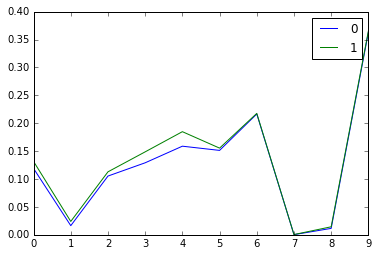

In [326]:
partial_hazard_ci.plot()
#sep_mdl.predict_partial_hazard(tdf[order]).plot(marker='*')


In [246]:
ftimes = identify_forecast_timepoints(sep_mdl,tdf, [0,1,2,3,4,5])
ftimes

,time_point_0,time_point_1,time_point_2,time_point_3,time_point_4,time_point_5
0,37.6235,38.6235,39.6235,40.6235,41.6235,42.6235
1,39.7919,40.7919,41.7919,42.7919,43.7919,44.7919
2,22.7105,23.7105,24.7105,25.7105,26.7105,27.7105
3,28.9802,29.9802,30.9802,31.9802,32.9802,33.9802
4,17.3251,18.3251,19.3251,20.3251,21.3251,22.3251
5,30.2368,31.2368,32.2368,33.2368,34.2368,35.2368
6,25.8864,26.8864,27.8864,28.8864,29.8864,30.8864
7,32.512,33.512,34.512,35.512,36.512,37.512
8,30.7488,31.7488,32.7488,33.7488,34.7488,35.7488
9,19.258,20.258,21.258,22.258,23.258,24.258


In [248]:
max_time = sep_mdl.baseline_hazard_.index.max()
max_time

58.040890641099999

In [251]:
ftimes[ftimes>max_time]= max_time

In [260]:
ftimes

,time_point_0,time_point_1,time_point_2,time_point_3,time_point_4,time_point_5
0,37.6235,38.6235,39.6235,40.6235,41.6235,42.6235
1,39.7919,40.7919,41.7919,42.7919,43.7919,44.7919
2,22.7105,23.7105,24.7105,25.7105,26.7105,27.7105
3,28.9802,29.9802,30.9802,31.9802,32.9802,33.9802
4,17.3251,18.3251,19.3251,20.3251,21.3251,22.3251
5,30.2368,31.2368,32.2368,33.2368,34.2368,35.2368
6,25.8864,26.8864,27.8864,28.8864,29.8864,30.8864
7,32.512,33.512,34.512,35.512,36.512,37.512
8,30.7488,31.7488,32.7488,33.7488,34.7488,35.7488
9,19.258,20.258,21.258,22.258,23.258,24.258


In [253]:
specific_cumulative_hazards = ftimes.applymap(lambda x: return_desired_cumulative_hazards(x,sep_mdl))
specific_cumulative_hazards

,time_point_0,time_point_1,time_point_2,time_point_3,time_point_4,time_point_5
0,3.206414,3.428802,3.603461,3.817723,4.056768,4.289903
1,3.635412,3.862306,4.115348,4.351108,4.826578,5.145398
2,1.068519,1.154241,1.253175,1.367308,1.500185,1.642238
3,1.807270,1.927553,2.045714,2.166316,2.343220,2.545376
4,0.651486,0.728181,0.810056,0.877749,0.957998,1.037331
5,1.965300,2.063630,2.213150,2.392120,2.602101,2.798073
6,1.385733,1.532630,1.672744,1.792102,1.918740,2.029859
7,2.271017,2.456926,2.661904,2.848879,3.010824,3.197364
8,2.010903,2.127801,2.313439,2.502925,2.711260,2.914867
9,0.804465,0.872153,0.949713,1.030887,1.113316,1.205945


In [289]:
pd.DataFrame(np.exp(np.multiply(specific_cumulative_hazards.values.T,phi.values[:,0])),columns=tdf.index).T

,0,1,2,3,4,5
0,0.030068,0.023580,0.019483,0.015415,0.011871,0.009201
1,0.018814,0.014682,0.011135,0.008606,0.005118,0.003612
2,0.311055,0.283237,0.254209,0.224398,0.194067,0.166160
3,0.167245,0.148479,0.132095,0.117236,0.098410,0.080568
4,0.474854,0.434994,0.396128,0.366630,0.334493,0.305493
5,0.143035,0.129774,0.111927,0.093761,0.076171,0.062744
6,0.253807,0.219471,0.191058,0.169775,0.149779,0.134184
7,0.086806,0.071065,0.056997,0.046608,0.039154,0.032032
8,0.114848,0.101272,0.082932,0.067633,0.054049,0.043413
9,0.246312,0.218920,0.191257,0.166041,0.143835,0.122405


In [290]:
sep_surv_pred['surv']

,t_0,t_1,t_2,t_3,t_4,t_5
0,0.669813,0.651452,0.637385,0.620542,0.602276,0.584980
1,0.930499,0.926325,0.921692,0.917396,0.908794,0.903070
2,0.890055,0.881777,0.872319,0.861534,0.849145,0.836098
3,0.778553,0.765690,0.753260,0.740782,0.722852,0.702893
4,0.894397,0.882722,0.870428,0.860392,0.848645,0.837189
5,0.739896,0.728828,0.712314,0.693039,0.671088,0.651229
6,0.740238,0.717008,0.695530,0.677742,0.659366,0.643653
7,0.999202,0.999137,0.999065,0.998999,0.998943,0.998877
8,0.974483,0.973020,0.970701,0.968339,0.965750,0.963225
9,0.746177,0.728019,0.707755,0.687151,0.666842,0.644736


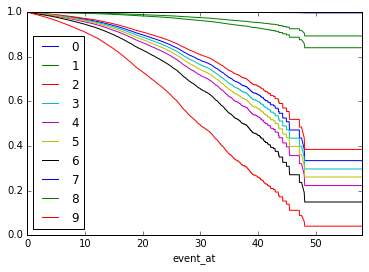

In [264]:
%matplotlib inline
sep_mdl.predict_survival_function(tdf).plot()


In [254]:
pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards.values,
                                                             ph.values)), index=tdf.index)


,0,1,2,3,4,5
0,0.669813,0.651452,0.637385,0.620542,0.602276,0.584980
1,0.930499,0.926325,0.921692,0.917396,0.908794,0.903070
2,0.890055,0.881777,0.872319,0.861534,0.849145,0.836098
3,0.778553,0.765690,0.753260,0.740782,0.722852,0.702893
4,0.894397,0.882722,0.870428,0.860392,0.848645,0.837189
5,0.739896,0.728828,0.712314,0.693039,0.671088,0.651229
6,0.740238,0.717008,0.695530,0.677742,0.659366,0.643653
7,0.999202,0.999137,0.999065,0.998999,0.998943,0.998877
8,0.974483,0.973020,0.970701,0.968339,0.965750,0.963225
9,0.746177,0.728019,0.707755,0.687151,0.666842,0.644736


In [329]:
sep_surv_pred['lbci']

,t_0,t_1,t_2,t_3,t_4,t_5
0,0.656093,0.637192,0.622731,0.605437,0.586710,0.569004
1,0.916562,0.911592,0.906080,0.900975,0.890767,0.883987
2,0.886394,0.877860,0.868112,0.857002,0.844245,0.830818
3,0.764396,0.750850,0.737775,0.724666,0.705857,0.684960
4,0.886567,0.874090,0.860964,0.850260,0.837743,0.825551
5,0.736922,0.725751,0.709090,0.689649,0.667518,0.647504
6,0.739716,0.716449,0.694938,0.677124,0.658722,0.642988
7,0.999028,0.998948,0.998861,0.998781,0.998711,0.998632
8,0.971523,0.969893,0.967310,0.964680,0.961797,0.958987
9,0.745482,0.727284,0.706977,0.686331,0.665983,0.643836


In [330]:
sep_surv_pred['ubci']

,t_0,t_1,t_2,t_3,t_4,t_5
0,0.683126,0.665307,0.651639,0.635255,0.617461,0.600588
1,0.942181,0.938685,0.934802,0.931198,0.923973,0.919159
2,0.893605,0.885577,0.876401,0.865933,0.853904,0.841229
3,0.791978,0.779780,0.767980,0.756120,0.739054,0.720024
4,0.901716,0.890800,0.879293,0.869892,0.858877,0.848124
5,0.742843,0.731877,0.715510,0.696400,0.674629,0.654925
6,0.740760,0.717566,0.696121,0.678359,0.660009,0.644317
7,0.999345,0.999292,0.999233,0.999179,0.999132,0.999079
8,0.977139,0.975826,0.973745,0.971625,0.969300,0.967033
9,0.746870,0.728752,0.708532,0.687969,0.667700,0.645634


In [331]:
sep_surv_pred['surv']

,t_0,t_1,t_2,t_3,t_4,t_5
0,0.669813,0.651452,0.637385,0.620542,0.602276,0.584980
1,0.930499,0.926325,0.921692,0.917396,0.908794,0.903070
2,0.890055,0.881777,0.872319,0.861534,0.849145,0.836098
3,0.778553,0.765690,0.753260,0.740782,0.722852,0.702893
4,0.894397,0.882722,0.870428,0.860392,0.848645,0.837189
5,0.739896,0.728828,0.712314,0.693039,0.671088,0.651229
6,0.740238,0.717008,0.695530,0.677742,0.659366,0.643653
7,0.999202,0.999137,0.999065,0.998999,0.998943,0.998877
8,0.974483,0.973020,0.970701,0.968339,0.965750,0.963225
9,0.746177,0.728019,0.707755,0.687151,0.666842,0.644736


In [212]:
sep_surv_pred['surv']

,t_0,t_1,t_2,t_3,t_4,t_5
0,0.669813,0.651452,0.637385,0.620542,0.602276,0.584980
1,0.930499,0.926325,0.921692,0.917396,0.908794,0.903070
2,0.890055,0.881777,0.872319,0.861534,0.849145,0.836098
3,0.778553,0.765690,0.753260,0.740782,0.722852,0.702893
4,0.894397,0.882722,0.870428,0.860392,0.848645,0.837189
5,0.739896,0.728828,0.712314,0.693039,0.671088,0.651229
6,0.740238,0.717008,0.695530,0.677742,0.659366,0.643653
7,0.999202,0.999137,0.999065,0.998999,0.998943,0.998877
8,0.974483,0.973020,0.970701,0.968339,0.965750,0.963225
9,0.746177,0.728019,0.707755,0.687151,0.666842,0.644736


In [332]:
#input_type = str(type(sep_surv_pred))
#if 'Panel' in input_type:
sep_prob = sep_surv_pred.copy()
for item in sep_surv_pred.items:
    sep_prob[item]=1-sep_surv_pred[item]

sep_prob
#print(sep_surv_pred[item].shape)

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 10 (major_axis) x 6 (minor_axis)
Items axis: lbci to ubci
Major_axis axis: 0 to 9
Minor_axis axis: t_0 to t_5

In [333]:
sep_prob['surv']

,t_0,t_1,t_2,t_3,t_4,t_5
0,0.330187,0.348548,0.362615,0.379458,0.397724,0.415020
1,0.069501,0.073675,0.078308,0.082604,0.091206,0.096930
2,0.109945,0.118223,0.127681,0.138466,0.150855,0.163902
3,0.221447,0.234310,0.246740,0.259218,0.277148,0.297107
4,0.105603,0.117278,0.129572,0.139608,0.151355,0.162811
5,0.260104,0.271172,0.287686,0.306961,0.328912,0.348771
6,0.259762,0.282992,0.304470,0.322258,0.340634,0.356347
7,0.000798,0.000863,0.000935,0.001001,0.001057,0.001123
8,0.025517,0.026980,0.029299,0.031661,0.034250,0.036775
9,0.253823,0.271981,0.292245,0.312849,0.333158,0.355264


In [335]:
sep_prob['ubci']#, sep_prob['ubci']
sep_prob['lbci']

,t_0,t_1,t_2,t_3,t_4,t_5
0,0.343907,0.362808,0.377269,0.394563,0.413290,0.430996
1,0.083438,0.088408,0.093920,0.099025,0.109233,0.116013
2,0.113606,0.122140,0.131888,0.142998,0.155755,0.169182
3,0.235604,0.249150,0.262225,0.275334,0.294143,0.315040
4,0.113433,0.125910,0.139036,0.149740,0.162257,0.174449
5,0.263078,0.274249,0.290910,0.310351,0.332482,0.352496
6,0.260284,0.283551,0.305062,0.322876,0.341278,0.357012
7,0.000972,0.001052,0.001139,0.001219,0.001289,0.001368
8,0.028477,0.030107,0.032690,0.035320,0.038203,0.041013
9,0.254518,0.272716,0.293023,0.313669,0.334017,0.356164


0    929965184037557
1    872454415016088
2    247046588569436
3    980835578861104
4    831802700567899
5    612245620047788
6    673774298594228
7     53680010164939
8    361010560468310
9    688423451822448
Name: KEY, dtype: object

In [341]:
pd.DataFrame(edf['KEY'])

,KEY
0,929965184037557
1,872454415016088
2,247046588569436
3,980835578861104
4,831802700567899
5,612245620047788
6,673774298594228
7,53680010164939
8,361010560468310
9,688423451822448


In [346]:
[a.replace('t','ret_pred') for a in sep_surv_pred.minor_axis.tolist()]

['ret_pred_0',
 'ret_pred_1',
 'ret_pred_2',
 'ret_pred_3',
 'ret_pred_4',
 'ret_pred_5']

In [357]:
len(ret_surv_pred['surv']), len(pd.DataFrame(edf['KEY']))

(8, 10)

In [396]:
""""def convert_surv_to_prob(surv_pred,pred_type,keyed_df):
    prob = surv_pred.copy()
    
    for item in surv_pred.items:
        prob[item] = pd.concat([keyed_df,1-surv_pred[item]],axis=1)
        
        #prob[item]=pd.concat([keyed_df,1-surv_pred[item]],axis=1)
                             
    # now check that lengths match
    #if len(surv_pred['surv'])!=len(keyed_df):
    #    for item in surv_pred.items:
    #        prob[item]
    #timepoint_cols = surv_pred.minor_axis.tolist()    
    if pred_type =='ret':
        rep_string = 'ret_prob'
    elif pred_type == 'sep':
        rep_string = 'sep_prob'
    
    prob.minor_axis = [a.replace('t',rep_string) for a in prob.minor_axis.tolist()]

    return prob
    """

In [400]:
r2 = convert_surv_to_prob(ret_surv_pred,'ret',kdf)
r2

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 8 (major_axis) x 6 (minor_axis)
Items axis: lbci to ubci
Major_axis axis: 0 to 9
Minor_axis axis: ret_prob_0 to ret_prob_5

In [401]:
r2['surv']

,ret_prob_0,ret_prob_1,ret_prob_2,ret_prob_3,ret_prob_4,ret_prob_5
0,0.714605,0.760385,0.801521,0.840423,0.875270,0.902407
1,0.490477,0.533840,0.578892,0.621604,0.673162,0.729349
2,0.169326,0.181262,0.194641,0.211339,0.227534,0.243582
5,0.206971,0.220267,0.237096,0.260972,0.290522,0.324579
6,0.148933,0.160962,0.172393,0.183705,0.193276,0.205493
7,0.216655,0.240781,0.269129,0.302119,0.340576,0.385182
8,0.123643,0.132615,0.145108,0.162531,0.182712,0.207977
9,0.061930,0.067385,0.072838,0.078567,0.084532,0.091365


In [407]:
def convert_surv_to_prob(surv_pred,pred_type,keyed_df):
    prob= {}
    
    for item in surv_pred.items:
        if item == 'lbci':
            prob['ubcip']= pd.concat([keyed_df,1-surv_pred[item]],axis=1)
            prob['ubcip'].fillna(0,inplace=True)
        elif item == 'ubci':
            prob['lbcip']= pd.concat([keyed_df,1-surv_pred[item]],axis=1)
            prob['lbcip'].fillna(0,inplace=True)
        else:
            prob['surv']=pd.concat([keyed_df,1-surv_pred[item]],axis=1)
            prob['surv'].fillna(0,inplace=True)
        
        
                             
    # now check that lengths match
    #if len(surv_pred['surv'])!=len(keyed_df):
    #    for item in surv_pred.items:
    #        prob[item]
    #timepoint_cols = surv_pred.minor_axis.tolist()    
    if pred_type =='ret':
        rep_string = 'ret_prob'
    elif pred_type == 'sep':
        rep_string = 'sep_prob'
        
    probabilities = pd.Panel.from_dict(prob)
    probabilities.minor_axis = [a.replace('t',rep_string) for a in probabilities.minor_axis.tolist()]

    return probabilities

In [408]:
ss = convert_surv_to_prob(sep_surv_pred,'sep',kdf)
ss

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 10 (major_axis) x 7 (minor_axis)
Items axis: lbcip to ubcip
Major_axis axis: 0 to 9
Minor_axis axis: KEY to sep_prob_5

In [416]:
rr['surv']

,KEY,ret_prob_0,ret_prob_1,ret_prob_2,ret_prob_3,ret_prob_4,ret_prob_5
0,929965184037557,0.714605,0.760385,0.801521,0.840423,0.87527,0.902407
1,872454415016088,0.490477,0.53384,0.578892,0.621604,0.673162,0.729349
2,247046588569436,0.169326,0.181262,0.194641,0.211339,0.227534,0.243582
3,980835578861104,0,0,0,0,0,0
4,831802700567899,0,0,0,0,0,0
5,612245620047788,0.206971,0.220267,0.237096,0.260972,0.290522,0.324579
6,673774298594228,0.148933,0.160962,0.172393,0.183705,0.193276,0.205493
7,53680010164939,0.216655,0.240781,0.269129,0.302119,0.340576,0.385182
8,361010560468310,0.123643,0.132615,0.145108,0.162531,0.182712,0.207977
9,688423451822448,0.0619303,0.0673854,0.0728379,0.0785674,0.0845317,0.0913649


In [424]:
#ss['surv'][]
#rr['surv'][
prob_cols = rr['surv'].columns.tolist()[1:]
(rr['surv'][prob_cols]>=0.5).astype(int).sum(axis=0)

ret_prob_0    1
ret_prob_1    2
ret_prob_2    2
ret_prob_3    2
ret_prob_4    2
ret_prob_5    2
dtype: int64

In [438]:
def reduce_to_sums(prob,thresh,pcols):
    my_counts ={}
    for item in prob.items:
        my_counts[item] = (prob[item][pcols]>=thresh).astype(int).sum(axis=0)
        
    df_counts = pd.DataFrame.from_dict(my_counts)
    
    return df_counts

In [439]:
rcounts = reduce_to_sums(rr,0.5,prob_cols)
scounts = reduce_to_sums(ss,0.5,ss['surv'].columns.tolist()[1:])

In [440]:
scounts

,lbcip,surv,ubcip
sep_prob_0,0,0,0
sep_prob_1,0,0,0
sep_prob_2,0,0,0
sep_prob_3,0,0,0
sep_prob_4,0,0,0
sep_prob_5,0,0,0


In [441]:
rcounts

,lbcip,surv,ubcip
ret_prob_0,1,1,1
ret_prob_1,2,2,2
ret_prob_2,2,2,2
ret_prob_3,2,2,2
ret_prob_4,2,2,2
ret_prob_5,2,2,2


In [432]:
rr.apply(lambda x: 1 if x>=0.5 else 0, axis=0)#[prob_cols]#.apply(lambda x: x.sum(), axis =0)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [409]:
rr= convert_surv_to_prob(ret_surv_pred,'ret',kdf)
rr

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 10 (major_axis) x 7 (minor_axis)
Items axis: lbcip to ubcip
Major_axis axis: 0 to 9
Minor_axis axis: KEY to ret_prob_5

In [411]:
rr['surv']

,KEY,ret_prob_0,ret_prob_1,ret_prob_2,ret_prob_3,ret_prob_4,ret_prob_5
0,929965184037557,0.714605,0.760385,0.801521,0.840423,0.87527,0.902407
1,872454415016088,0.490477,0.53384,0.578892,0.621604,0.673162,0.729349
2,247046588569436,0.169326,0.181262,0.194641,0.211339,0.227534,0.243582
3,980835578861104,0,0,0,0,0,0
4,831802700567899,0,0,0,0,0,0
5,612245620047788,0.206971,0.220267,0.237096,0.260972,0.290522,0.324579
6,673774298594228,0.148933,0.160962,0.172393,0.183705,0.193276,0.205493
7,53680010164939,0.216655,0.240781,0.269129,0.302119,0.340576,0.385182
8,361010560468310,0.123643,0.132615,0.145108,0.162531,0.182712,0.207977
9,688423451822448,0.0619303,0.0673854,0.0728379,0.0785674,0.0845317,0.0913649


In [412]:
edf['Age_years']

0    62.614648
1    53.596167
2    61.284052
3    49.798768
4    43.887748
5    55.920602
6    54.373717
7    60.492813
8    53.741273
9    52.843258
Name: Age_years, dtype: float64

In [368]:
kdf = pd.DataFrame(edf['KEY'])
pd.concat([kdf,sep_surv_pred['surv']],axis=1)

,KEY,t_0,t_1,t_2,t_3,t_4,t_5
0,929965184037557,0.669813,0.651452,0.637385,0.620542,0.602276,0.584980
1,872454415016088,0.930499,0.926325,0.921692,0.917396,0.908794,0.903070
2,247046588569436,0.890055,0.881777,0.872319,0.861534,0.849145,0.836098
3,980835578861104,0.778553,0.765690,0.753260,0.740782,0.722852,0.702893
4,831802700567899,0.894397,0.882722,0.870428,0.860392,0.848645,0.837189
5,612245620047788,0.739896,0.728828,0.712314,0.693039,0.671088,0.651229
6,673774298594228,0.740238,0.717008,0.695530,0.677742,0.659366,0.643653
7,53680010164939,0.999202,0.999137,0.999065,0.998999,0.998943,0.998877
8,361010560468310,0.974483,0.973020,0.970701,0.968339,0.965750,0.963225
9,688423451822448,0.746177,0.728019,0.707755,0.687151,0.666842,0.644736


In [381]:
prob=sep_surv_pred.copy()
for item in sep_surv_pred.items:
    prob[item]=1-sep_surv_pred[item]
    

In [380]:
for item in sep_surv_pred.items:
    print(item)
    prob[item]

lbci
surv
ubci


In [392]:
ret_surv_pred['surv']

,t_0,t_1,t_2,t_3,t_4,t_5
0,0.285395,0.239615,0.198479,0.159577,0.124730,0.097593
1,0.509523,0.466160,0.421108,0.378396,0.326838,0.270651
2,0.830674,0.818738,0.805359,0.788661,0.772466,0.756418
5,0.793029,0.779733,0.762904,0.739028,0.709478,0.675421
6,0.851067,0.839038,0.827607,0.816295,0.806724,0.794507
7,0.783345,0.759219,0.730871,0.697881,0.659424,0.614818
8,0.876357,0.867385,0.854892,0.837469,0.817288,0.792023
9,0.938070,0.932615,0.927162,0.921433,0.915468,0.908635


In [404]:
ss = convert_surv_to_prob(sep_surv_pred,'sep',kdf)
ss['lbcip']

,KEY,t_0,t_1,t_2,t_3,t_4,t_5
0,929965184037557,0.316874,0.334693,0.348361,0.364745,0.382539,0.399412
1,872454415016088,0.057819,0.061315,0.065198,0.068802,0.076027,0.080841
2,247046588569436,0.106395,0.114423,0.123599,0.134067,0.146096,0.158771
3,980835578861104,0.208022,0.220220,0.232020,0.243880,0.260946,0.279976
4,831802700567899,0.098284,0.109200,0.120707,0.130108,0.141123,0.151876
5,612245620047788,0.257157,0.268123,0.284490,0.303600,0.325371,0.345075
6,673774298594228,0.259240,0.282434,0.303879,0.321641,0.339991,0.355683
7,53680010164939,0.000655,0.000708,0.000767,0.000821,0.000868,0.000921
8,361010560468310,0.022861,0.024174,0.026255,0.028375,0.030700,0.032967
9,688423451822448,0.253130,0.271248,0.291468,0.312031,0.332300,0.354366


In [405]:
ss

{'lbcip':                KEY       t_0       t_1       t_2       t_3       t_4       t_5
 0  929965184037557  0.316874  0.334693  0.348361  0.364745  0.382539  0.399412
 1  872454415016088  0.057819  0.061315  0.065198  0.068802  0.076027  0.080841
 2  247046588569436  0.106395  0.114423  0.123599  0.134067  0.146096  0.158771
 3  980835578861104  0.208022  0.220220  0.232020  0.243880  0.260946  0.279976
 4  831802700567899  0.098284  0.109200  0.120707  0.130108  0.141123  0.151876
 5  612245620047788  0.257157  0.268123  0.284490  0.303600  0.325371  0.345075
 6  673774298594228  0.259240  0.282434  0.303879  0.321641  0.339991  0.355683
 7   53680010164939  0.000655  0.000708  0.000767  0.000821  0.000868  0.000921
 8  361010560468310  0.022861  0.024174  0.026255  0.028375  0.030700  0.032967
 9  688423451822448  0.253130  0.271248  0.291468  0.312031  0.332300  0.354366,
 'surv':                KEY       t_0       t_1       t_2       t_3       t_4       t_5
 0  929965184037557  0

In [376]:
ss['surv']

,sep_prob_0,sep_prob_1,sep_prob_2,sep_prob_3,sep_prob_4,sep_prob_5
0,0.330187,0.348548,0.362615,0.379458,0.397724,0.415020
1,0.069501,0.073675,0.078308,0.082604,0.091206,0.096930
2,0.109945,0.118223,0.127681,0.138466,0.150855,0.163902
3,0.221447,0.234310,0.246740,0.259218,0.277148,0.297107
4,0.105603,0.117278,0.129572,0.139608,0.151355,0.162811
5,0.260104,0.271172,0.287686,0.306961,0.328912,0.348771
6,0.259762,0.282992,0.304470,0.322258,0.340634,0.356347
7,0.000798,0.000863,0.000935,0.001001,0.001057,0.001123
8,0.025517,0.026980,0.029299,0.031661,0.034250,0.036775
9,0.253823,0.271981,0.292245,0.312849,0.333158,0.355264


In [ ]:
sep_proba = 1-sep_surv_pred['surv']
sep_proba['KEY']=current.KEY
sep_proba.columns = ['sep_prob0','sep_prob1','sep_prob2','sep_prob3','sep_prob4','sep_prob5']

In [353]:
## for retirement
ret_df = tdf[tdf['Age_years']>=50.0].copy()

ret_surv_pred = forecast_survival_function(ret_mdl, ret_df[rcols], time_range=[0,1,2,3,4,5], calc_ci=True, extrapolate=False)

In [371]:
rr = convert_surv_to_prob(ret_surv_pred,'ret',kdf)

In [373]:
rr['surv']

,ret_prob_0,ret_prob_1,ret_prob_2,ret_prob_3,ret_prob_4,ret_prob_5
0,0.714605,0.760385,0.801521,0.840423,0.875270,0.902407
1,0.490477,0.533840,0.578892,0.621604,0.673162,0.729349
2,0.169326,0.181262,0.194641,0.211339,0.227534,0.243582
5,0.206971,0.220267,0.237096,0.260972,0.290522,0.324579
6,0.148933,0.160962,0.172393,0.183705,0.193276,0.205493
7,0.216655,0.240781,0.269129,0.302119,0.340576,0.385182
8,0.123643,0.132615,0.145108,0.162531,0.182712,0.207977
9,0.061930,0.067385,0.072838,0.078567,0.084532,0.091365


In [354]:
ret_surv_pred

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 8 (major_axis) x 6 (minor_axis)
Items axis: lbci to ubci
Major_axis axis: 0 to 9
Minor_axis axis: t_0 to t_5

In [355]:
ret_surv_pred['surv']

,t_0,t_1,t_2,t_3,t_4,t_5
0,0.285395,0.239615,0.198479,0.159577,0.124730,0.097593
1,0.509523,0.466160,0.421108,0.378396,0.326838,0.270651
2,0.830674,0.818738,0.805359,0.788661,0.772466,0.756418
5,0.793029,0.779733,0.762904,0.739028,0.709478,0.675421
6,0.851067,0.839038,0.827607,0.816295,0.806724,0.794507
7,0.783345,0.759219,0.730871,0.697881,0.659424,0.614818
8,0.876357,0.867385,0.854892,0.837469,0.817288,0.792023
9,0.938070,0.932615,0.927162,0.921433,0.915468,0.908635


## Define the current employees

In [ ]:
current = empl[empl.status == 0].copy()

## Look at importing the relative version of the module of interest

In [ ]:
working_dir = u'C:/Users/kesj/Documents/projects/HRattrition/reduced/'
ll_repo = u'C:/Users/kesj/code/lifelines'


In [ ]:
import os,subprocess,sys
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import chain
import random
import seaborn as sns
from glob import glob
plt.style.use('ggplot')

In [ ]:
os.chdir(ll_repo)

In [ ]:
sm_cols = ['Age_years','Tenure_years','former','HAVE_DEP','ANNUAL_RT','SEX','HAVE_INS','PERF1','BOX1','REH_CNT','DIRECT_RPT_CNT','DEPTCNT1','LOCCNT1','EXTFUNC_CNT','LOCSTCNT1','HUBIND','REMOTE','INTERN']

In [ ]:
current[sm_cols].isnull().any()

## build a model from these features

In [ ]:
import lifelines as ll

In [ ]:
# repeat the split
from sklearn import cross_validation
# break into evaluation and build sets
print("Starting with subset of {0} employees.".format(len(empl)))
eval_fraction = 0.20
e2build, e2eval = cross_validation.train_test_split(empl,test_size=eval_fraction,random_state = 57843)
print("Evaluation set has {0} employees; training set has {1} employees.".format(len(e2eval),len(e2build)))

In [ ]:
%%time 
cf = ll.CoxPHFitter()
scores = ll.utils.k_fold_cross_validation(cf,e2build[sm_cols],'Tenure_years','former')

In [ ]:
cf.print_summary()

In [ ]:
scores

In [ ]:
import lifelines as ll

In [ ]:
reload(ll)

In [ ]:
%%time 
cf2 = ll.CoxPHFitter()
scores2 = ll.utils.k_fold_cross_validation(cf2,e2build[sm_cols[:-1]],'Tenure_years','former')

In [ ]:
cf3 = ll.CoxPHFitter()


In [ ]:
cf3.

In [ ]:
print(scores2)
cf2.print_summary()

In [ ]:
cf2.print_summary()

In [ ]:
import pickle

In [ ]:
os.chdir(working_dir)

In [ ]:
pickle.dump(cf2, open( 'coxph_sep_survM1.pkl','wb'))

# Start with the model

In [ ]:
from glob import glob
from __future__ import print_function

In [ ]:
MDL_BASE_PATH  = u'C:/Users/kesj/code/hrsep1/smodel/'
pkl_files =glob(MDL_BASE_PATH+'*.pkl')
print(pkl_files)

In [ ]:
p2 = []
p2+=pkl_files
p2.append('retirement_cf0.pkl')

In [ ]:
p2.append('')

In [ ]:
[a for a in p2 if 'retirement' in a]

In [ ]:
mdl = pickle.load(open(pkl_files[0],'rb'))

In [ ]:
mdl.print_summary()

In [ ]:
m2 = pickle.load(open(pkl_files[1],'rb'))

In [ ]:
m2.print_summary()

In [ ]:
#m2.event_observed.name, m2.durations.name, m2.hazards_.columns.tolist()
os.chdir("../../../projects/HRattrition/webserverTest/")
%ls

In [ ]:
os.path.abspath('model_1')

In [ ]:
td1 = pd.read_csv(tdata1,delimiter=';')

In [ ]:
my_cols = ['KEY','HIRE_DT','BIRTHDATE','HAVE_INS','HAVE_DEP','EMPL_TYPE','SAL1']
td1[my_cols]

In [ ]:
td1.KEY

In [ ]:
td1.TERMINATION_DT

In [ ]:
histcurr_header_line = '"KEY";"PER_ORG";"LOCATION";"LOC_TYPE_DESCR_SFI";"JOBCODE";"LEGACY_DEPT_SFI";"FULL_PART_TIME";"EMPL_TYPE";"SHIFT";"COMPANY";"STD_HOURS";"EMPL_CLASS";"GRADE";"COMP_FREQUENCY";"ANNUAL_RT";"FLSA_STATUS";"FTE";"FLOR_SFI";"EEO1CODE";"EXT_FUNC_ID_SFI";"FUNC_ID_SFI";"DIVISION_CODE_SFI";"JOB_FAMILY";"JOB_FUNCTION";"LOC_STATE";"LOC_CITY";"MAX_RT_ANNUAL";"MIN_RT_ANNUAL";"TERMINATION_DT";"HUBIND";"REMOTE";"SUPV_DIFF_LOC";"REMOTE_SUPV";"LOCCNT1";"LOCCNT3";"LOCCNT5";"LOCCNT10";"JOBCNT1";"JOBCNT3";"JOBCNT5";"JOBCNT10";"DEPTCNT1";"DEPTCNT3";"DEPTCNT5";"DEPTCNT10";"GRADECNT1";"GRADECNT3";"GRADECNT5";"GRADECNT10";"FLOORCNT1";"FLOORCNT3";"FLOORCNT5";"FLOORCNT10";"SUPVCNT1";"SUPVCNT3";"SUPVCNT5";"SUPVCNT10";"FUNCCNT1";"FUNCCNT3";"FUNCCNT5";"FUNCCNT10";"EFUNCCNT1";"EFUNCCNT3";"EFUNCCNT5";"EFUNCCNT10";"LOCSTCNT1";"LOCSTCNT3";"LOCSTCNT5";"LOCSTCNT10";"FTPTCNT1";"FTPTCNT3";"FTPTCNT5";"FTPTCNT10";"PTFTCNT1";"PTFTCNT3";"PTFTCNT5";"PTFTCNT10";"FULLPART1";"FULLPART3";"FULLPART5";"FULLPART10";"PARTFULL1";"PARTFULL3";"PARTFULL5";"PARTFULL10";"REH_CNT";"INTERN";"CUR_LOC_MOS";"CUR_JOB_MOS";"CUR_GRADE_MOS";"CUR_DEPT_MOS";"CUR_FUNC_MOS";"CUR_EFUNC_MOS";"TELE_MOS";"ACTRES1";"ACTRES2";"ACTRES3";"ACTRES4";"ACTRES5";"ACTRES6";"ACTRES7";"ACTRES8";"ACTRES9";"ACTRES10";"BOX1";"BOX2";"BOX3";"BOX4";"BOX5";"BOX6";"BOX7";"BOX8";"BOX9";"BOX10";"RATE1";"RATE2";"RATE3";"RATE4";"RATE5";"RATE6";"RATE7";"RATE8";"RATE9";"RATE10";"SAL1";"SAL2";"SAL3";"SAL4";"SAL5";"SAL6";"SAL7";"SAL8";"SAL9";"SAL10";"MERIT1";"MERIT2";"MERIT3";"MERIT4";"MERIT5";"MERIT6";"MERIT7";"MERIT8";"MERIT9";"MERIT10";"PERF1";"PERF2";"PERF3";"PERF4";"PERF5";"PERF6";"PERF7";"PERF8";"PERF9";"PERF10";"SKEY";"DIRECT_RPT_CNT";"TOTAL_RPT_CNT";"COUNT";"COUNT"'

## Clean up the histcurr_header_line
1. replace last two elements in histcurr_header_line
    * 'COUNT':'FUNC_CNT','COUNT':'EXTFUNC_CNT'
2. append HAVE_INS & HAVE_DEP


In [ ]:
header_line = ';'.join(histcurr_header_line.split(';')[:-2])
header_line+=';"FUNC_CNT";"EXTFUNC_CNT";"HAVE_INS";"HAVE_DEP"'
header_line

In [ ]:
ex1

In [ ]:
ex1 = '"929965184037557";"EMP";"19921";"OPERATIONS CENTER";"8017";"119804921";"F";"E";"1";"001";"38.75";"1";"PA4";"A";"52324.290000";"N";"1.00";"999";"5";"00182";"00001";"9";"FINAST";"PSA";"FL";"WINTER HAVEN";"53163.450";"33153.340";"";"N";"N";"Y";"N";"0";"0";"0";"0";"1";"2";"2";"2";"1";"2";"2";"2";"0";"0";"1";"1";"0";"0";"0";"0";"2";"3";"5";"10";"0";"0";"0";"0";"1";"2";"2";"2";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"N";"N";"N";"N";"N";"N";"N";"N";"0";"N";"197.193548";"10.9677419";"46.8387097";"10.9677419";"316.806452";"10.9677419";"0";"RRTR W/JOB NUMBER CHANGE;INCENTIVE;MERIT;MISCELLANEOUS DATA CHANGE";"MISCELLANEOUS DATA CHANGE;INCENTIVE;MERIT";"TRANSFER W/ JOB NUMBER CHANGE;INCENTIVE;MERIT";"MISCELLANEOUS DATA CHANGE;JOB RECLASSIFICATION;INCENTIVE;MERIT";"MISCELLANEOUS DATA CHANGE;INCENTIVE;MERIT";"MISCELLANEOUS DATA CHANGE;MERIT";"MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA CHANGE;MERIT";"MISCELLANEOUS DATA CHANGE;MERIT";"MISCELLANEOUS DATA CHANGE;MERIT";"MISCELLANEOUS DATA CHANGE;MERIT";"S";"S";"S";"H";"H";"H";"S";"S";"S";"S";"R2C2";"R2C2";"R2C2";"R3C3";"R3C3";"R3C2";"R2C2";"R2C3";"R2C2";"R2C2";"52324.29";"51137.89";"50174.54";"49190.73";"48131.83";"47141.85";"46104.5";"45129.7";"44353.51";"43698.04";"1186.4";"963.35";"983.81";"1058.9";"989.98";"1037.35";"974.8";"776.19";"655.47";"722";"2904.63";"3050.61";"2951.44";"3754.28";"3724.21";"3112.05";"2635.57";"2328.56";"1529.43";"1856.56";"224608515493855";"9";"9";"1100";"116"'

In [ ]:
ex2 = '"872454415016088";"EMP";"00915";"CORPORATE HEADQUARTERS";"8017";"100804852";"F";"E";"1";"001";"38.75";"1";"PA4";"A";"57474.000000";"N";"1.00";"852";"5";"00182";"00001";"9";"FINAST";"PSA";"IL";"BLOOMINGTON";"57474.000";"35841.450";"";"Y";"N";"N";"N";"1";"2";"3";"3";"1";"2";"3";"3";"1";"2";"4";"4";"0";"0";"1";"1";"1";"1";"1";"1";"1";"2";"6";"10";"0";"0";"2";"2";"1";"2";"4";"4";"0";"0";"1";"1";"0";"0";"0";"0";"0";"0";"0";"0";"N";"N";"N";"N";"N";"N";"N";"N";"0";"N";"10.9677419";"10.9677419";"46.8387097";"10.9677419";"40.5806452";"10.9677419";"0";"TRANSFER W/ JOB NUMBER CHANGE;INCENTIVE;MERIT";"MISCELLANEOUS DATA CHANGE;INCENTIVE;MERIT;LOCATION/FLOOR CHANGE";"JOB CODE CHANGE;INCENTIVE;MERIT";"TRANSFER W/O JOB NUMBER CHANGE;MISCELLANEOUS DATA CHANGE;SALARY ADJUSTMENT;RRTR W/JOB NUMBER CHANGE;JOB RECLASSIFICATION;INCENTIVE;MERIT";"MISCELLANEOUS DATA CHANGE;INCENTIVE;MERIT;MISCELLANEOUS DATA CHANGE";"MERIT";"MISCELLANEOUS DATA CHANGE;DIVORCE/LEGAL SEP/ANNULMENT;MERIT";"MISCELLANEOUS DATA CHANGE;MERIT";"MISCELLANEOUS DATA CHANGE;MERIT";"MISCELLANEOUS DATA CHANGE;MERIT;MISCELLANEOUS DATA CHANGE";"H";"H";"H";"H";"H";"H";"S";"S";"S";"S";"R3C3";"R3C3";"R3C2";"R3C2";"R3C2";"R3C2";"R2C2";"R2C2";"R2C2";"R2C2";"57474";"57474";"56208.87";"54972";"50070.42";"49345.05";"48377.5";"48377.5";"48377.5";"48003.99";"0";"1265.13";"1236.87";"4901.58";"725.37";"967.55";"0";"0";"373.51";"793.14";"4080.65";"4271.87";"3710.61";"2733.84";"2728.78";"2902.65";"2472.09";"2176.99";"1680.14";"2039.51";"224608515493855";"9";"9";"1100";"116"'
ex3 = '"247046588569436";"EMP";"00915";"CORPORATE HEADQUARTERS";"8017";"100804852";"F";"E";"1";"001";"38.75";"1";"PA4";"A";"51589.960000";"N";"1.00";"852";"5";"00182";"00001";"9";"FINAST";"PSA";"IL";"BLOOMINGTON";"57474.000";"35841.450";"";"Y";"N";"N";"N";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"1";"2";"0";"0";"0";"0";"0";"2";"5";"9";"0";"1";"1";"1";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"N";"N";"N";"N";"N";"N";"N";"N";"0";"N";"272.354839";"154.483871";"46.8387097";"154.935484";"45.8387097";"154.935484";"0";"INCENTIVE;MERIT";"INCENTIVE;MERIT";"MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA CHANGE;INCENTIVE;MERIT";"MISCELLANEOUS DATA CHANGE;JOB RECLASSIFICATION;INCENTIVE;MERIT";"MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA CHANGE;INCENTIVE;MERIT";"JOB RECLASSIFICATION;MERIT";"MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA CHANGE;MERIT";"MERIT";"MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA CHANGE;MERIT";"BENEFITS TRANSACTION;MISCELLANEOUS DATA CHANGE;MERIT";"S";"H";"H";"H";"H";"S";"H";"H";"H";"S";"R2C2";"R3C2";"R3C2";"R3C2";"R3C2";"R2C3";"R3C2";"R3C3";"R3C2";"R2C2";"51589.96";"50014.5";"47860.77";"45997.86";"44571.57";"43189.51";"42136.11";"41136.49";"39252.38";"37724.54";"1575.46";"2153.73";"1862.91";"1426.29";"1382.06";"1053.4";"999.62";"1884.11";"1527.84";"1034.65";"1925.56";"2153.73";"2276.89";"2139.44";"2073.1";"3160.21";"2702.67";"2041.12";"1867.36";"1166.74";"224608515493855";"9";"9";"1100";"116"'

In [ ]:
ex4 = '"980835578861104";"EMP";"24921";"OPERATIONS CENTER";"5405";"124021921";"F";"E";"1";"001";"38.75";"1";"PA3";"A";"47034.760000";"N";"1.00";"999";"5";"00086";"00006";"9";"SRVTCH";"PSA";"AZ";"TEMPE";"51294.000";"31045.350";"";"Y";"N";"Y";"N";"0";"1";"2";"3";"1";"2";"3";"3";"0";"1";"2";"5";"0";"1";"3";"3";"0";"0";"0";"0";"0";"3";"7";"12";"0";"0";"0";"0";"0";"1";"2";"3";"0";"0";"1";"1";"0";"0";"0";"0";"0";"0";"0";"0";"N";"N";"N";"N";"N";"N";"N";"N";"0";"N";"29.7741935";"10.516129";"29.7741935";"29.7741935";"159.967742";"29.7741935";"0";"JOB CODE CHANGE;TRANSFER W/O JOB NUMBER CHANGE;INCENTIVE;MERIT";"MISCELLANEOUS DATA CHANGE;INCENTIVE;MERIT";"TRANSFER WITH PROMOTION;ORGANIZATIONAL CHANGES;INCENTIVE;MERIT;MISCELLANEOUS DATA CHANGE";"RRTR W/JOB NUMBER CHANGE;MISCELLANEOUS DATA CHANGE;JOB RECLASSIFICATION;INCENTIVE;MERIT";"MISCELLANEOUS DATA CHANGE;INCENTIVE;MERIT;MISCELLANEOUS DATA CHANGE";"MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA CHANGE;MERIT";"TRANSFER W/O JOB NUMBER CHANGE;TRANSFER W/O JOB NUMBER CHANGE;SALARY PLAN CHANGE;MERIT;MISCELLANEOUS DATA CHANGE";"MERIT";"MERIT";"LOCATION/FLOOR CHANGE;MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA CHANGE;MERIT";"H";"S";"S";"H";"H";"S";"H";"H";"H";"H";"R3C2";"R2C2";"R2C2";"R3C2";"R3C2";"R2C3";"R3C2";"R3C2";"R3C2";"R3C2";"47034.76";"45709.19";"42152.54";"55659.03";"54696.37";"53792.65";"52737.89";"51216.75";"51216.75";"51093.43";"1325.57";"1758.05";"622.94";"962.66";"903.72";"1054.76";"1521.14";"0";"123.32";"1391.65";"3245.35";"1758.05";"1868.83";"3413.05";"3399.7";"3164.27";"4112.71";"3457.13";"3576.54";"3578.53";"891514454452095";"7";"7";"2670";"272"'

In [ ]:
ex5 = '"831802700567899";"EMP";"00915";"CORPORATE HEADQUARTERS";"0896";"10096583289";"F";"S";"1";"001";"38.75";"1";"RA4";"A";"83240.000000";"Z";"1.00";"832";"2";"01001";"01000";"9";"ACTREP";"PTA";"IL";"BLOOMINGTON";"117249.610";"70877.630";"";"Y";"N";"N";"N";"0";"1";"1";"1";"0";"1";"1";"1";"1";"2";"2";"2";"0";"1";"1";"1";"0";"1";"1";"1";"2";"3";"3";"3";"0";"1";"1";"1";"0";"1";"1";"1";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"N";"N";"N";"N";"N";"N";"N";"N";"1";"N";"16.6129032";"16.6129032";"16.6129032";"16.6129032";"16.6129032";"16.6129032";"0";"MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA CHANGE;INCENTIVE;MERIT;TRANSFER W/O JOB NUMBER CHANGE";"REHIRE";"";"";"";"";"";"";"";"";"S";"";"";"";"";"";"";"";"";"";"R2C2";"";"";"";"";"";"";"";"";"";"83240";"0";"0";"0";"0";"0";"0";"0";"0";"0";"3240";"0";"0";"0";"0";"0";"0";"0";"0";"0";"2160";"0";"0";"0";"0";"0";"0";"0";"0";"0";"193562264644337";"8";"8";"337";"337"'

In [ ]:
ex6 = '"612245620047788";"EMP";"16928";"OPERATIONS CENTER";"5403";"116021928";"F";"E";"1";"001";"38.75";"1";"RA1";"A";"57409.500000";"N";"1.00";"999";"2";"00086";"00006";"9";"OPRSPC";"PTA";"OH";"COLUMBUS";"63700.350";"35830.250";"";"N";"N";"Y";"N";"0";"0";"0";"0";"1";"1";"1";"1";"0";"0";"0";"1";"0";"0";"1";"1";"0";"0";"0";"0";"1";"1";"1";"2";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"N";"N";"N";"N";"N";"N";"N";"N";"0";"N";"139.677419";"7.67741935";"43.5483871";"103.806452";"159.967742";"159.967742";"0";"JOB CODE CHANGE;INCENTIVE;MERIT;MISCELLANEOUS DATA CHANGE;TRANSFER W/O JOB NUMBER CHANGE";"INCENTIVE;MERIT";"TRANSFER W/O JOB NUMBER CHANGE;INCENTIVE;MERIT";"JOB RECLASSIFICATION;INCENTIVE;MERIT;ORGANIZATIONAL CHANGES";"INCENTIVE;MERIT";"MARRIAGE;MERIT";"MERIT";"MERIT";"TRANSFER W/O JOB NUMBER CHANGE;MERIT";"MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA CHANGE;MERIT";"S";"S";"S";"S";"S";"S";"S";"S";"S";"S";"R2C2";"R2C2";"R2C2";"R2C2";"R2C2";"R2C2";"R2C2";"R2C2";"R2C2";"R2C2";"57409.5";"56394.4";"55560.99";"54875.05";"54417.94";"53921.86";"53124.99";"52083.32";"51364.22";"50456.01";"1015.1";"833.41";"685.94";"457.11";"496.08";"796.87";"1041.67";"719.1";"908.21";"833.66";"2368.56";"1944.63";"2057.81";"1719.61";"1660.79";"2390.62";"3125";"1849.11";"2119.15";"2143.69";"40634222813246";"16";"16";"2670";"272"'

In [ ]:
ex7 ='"673774298594228";"EMP";"00915";"CORPORATE HEADQUARTERS";"5408";"10082080400";"F";"E";"1";"001";"38.75";"1";"PA4";"A";"52224.790000";"N";"1.00";"804";"5";"00196";"00006";"9";"ADMTCH";"PSA";"IL";"BLOOMINGTON";"57474.000";"35841.450";"";"Y";"N";"N";"N";"0";"0";"0";"1";"1";"1";"2";"3";"0";"0";"0";"1";"0";"0";"2";"3";"0";"0";"0";"1";"0";"2";"4";"7";"0";"0";"0";"0";"0";"0";"0";"1";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"N";"N";"N";"N";"N";"N";"N";"N";"0";"N";"94.6774194";"10.9677419";"46.3870968";"94.6774194";"213.741935";"94.6774194";"0";"JOB CODE CHANGE;INCENTIVE;MERIT";"MISCELLANEOUS DATA CHANGE;INCENTIVE;MERIT";"MISCELLANEOUS DATA CHANGE;INCENTIVE;MERIT";"MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA CHANGE;ORGANIZATIONAL CHANGES;PROMOTION;JOB RECLASSIFICATION;INCENTIVE;MERIT";"INCENTIVE;MERIT";"MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA CHANGE;MERIT";"MERIT";"TRANSFER W/ JOB NUMBER CHANGE;MERIT";"MERIT";"MISCELLANEOUS DATA CHANGE;MERIT";"S";"H";"H";"H";"H";"S";"H";"H";"H";"S";"R2C2";"R3C2";"R3C2";"R3C2";"R3C2";"R2C2";"R3C3";"R3C3";"R3C3";"R2C3";"52224.79";"51331.62";"50011.32";"44920.28";"44048.13";"43320.35";"42575.28";"40165.36";"38502.07";"36844.09";"893.17";"1320.3";"1946.62";"872.15";"727.78";"745.07";"2409.92";"1663.29";"1657.98";"1495.25";"2186.73";"4180.95";"2379.2";"3092.18";"2737.85";"2235.2";"2409.92";"1801.9";"2026.42";"1686.14";"316711196823377";"8";"8";"2670";"74"'

In [ ]:
ex8 = '"53680010164939";"EMP";"11P1D";"TELEWORKER - MOBILE";"3848";"111031P1DZ0";"F";"S";"1";"001";"38.75";"1";"FA6";"A";"170000.000000";"Z";"1.00";"999";"2";"00101";"00009";"9";"AGYSLR";"NSA";"KY";"LEXINGTON";"0.000";"0.000";"";"N";"Y";"Y";"N";"0";"1";"1";"1";"0";"1";"1";"1";"0";"1";"1";"1";"0";"1";"1";"1";"0";"0";"0";"0";"0";"0";"1";"4";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"N";"N";"N";"N";"N";"N";"N";"N";"1";"N";"21.0322581";"21.0322581";"21.0322581";"21.0322581";"287.967742";"287.967742";"8.61290323";"SALARY ADJUSTMENT;SALARY ADJUSTMENT";"TRANSFER W/ JOB NUMBER CHANGE;MERIT";"MERIT";"MERIT";"MISCELLANEOUS DATA CHANGE;MERIT";"MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA CHANGE;MERIT";"MISCELLANEOUS DATA CHANGE;SALARY PLAN CHANGE;MERIT";"MERIT";"MERIT;SALARY PLAN CHANGE";"MISCELLANEOUS DATA CHANGE;MERIT";"H";"H";"S";"H";"H";"S";"H";"H";"H";"H";"R3C2";"R3C2";"R2C2";"R3C2";"R3C2";"R2C3";"R3C3";"R3C2";"R3C2";"R3C2";"170000";"215000";"215000";"215000";"215000";"215000";"215000";"215000";"214848.12";"206584.73";"-45000";"0";"0";"0";"0";"0";"0";"151.88";"8263.39";"11693.48";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"28185155255806";"12";"12";"3746";"508"'

In [ ]:
ex9 ='"361010560468310";"EMP";"00915";"CORPORATE HEADQUARTERS";"3528";"10003284300";"F";"S";"1";"001";"38.75";"1";"MG4";"A";"142386.110000";"Z";"1.00";"843";"1";"00702";"00009";"9";"MANGER";"MGT";"IL";"BLOOMINGTON";"152885.060";"86782.970";"";"Y";"N";"N";"N";"0";"0";"1";"2";"0";"1";"1";"2";"0";"0";"4";"5";"0";"0";"0";"0";"0";"0";"1";"2";"0";"0";"2";"7";"0";"0";"0";"0";"0";"0";"1";"2";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"N";"N";"N";"N";"N";"N";"N";"N";"0";"N";"47.7419355";"36.2258065";"152.580645";"36.7096774";"276.774194";"54.6129032";"0";"MERIT";"MERIT";"MERIT;JOB CODE CHANGE";"TRANSFER W/O JOB NUMBER CHANGE;MISCELLANEOUS DATA CHANGE;MERIT;TRANSFER W/O JOB NUMBER CHANGE;TRANSFER W/O JOB NUMBER CHANGE";"TRANSFER W/O JOB NUMBER CHANGE;MERIT";"MERIT";"MISCELLANEOUS DATA CHANGE;MERIT";"TRANSFER W/O JOB NUMBER CHANGE;MERIT";"MERIT";"MISCELLANEOUS DATA CHANGE;TRANSFER W/ JOB NUMBER CHANGE;MISCELLANEOUS DATA CHANGE;MERIT;MISCELLANEOUS DATA CHANGE";"S";"H";"S";"S";"S";"H";"H";"S";"S";"S";"R2C2";"R3C2";"R2C3";"R2C2";"R2C2";"R3C3";"R3C2";"R2C2";"R2C2";"R2C2";"142386.11";"139594.23";"135528.38";"130315.75";"128389.9";"126492.51";"121627.41";"116949.43";"114097";"112410.84";"2791.88";"4065.85";"5212.63";"1925.85";"1897.39";"4865.1";"4677.98";"2852.43";"1686.16";"3580.52";"0";"0";"0";"0";"0";"0";"0";"0";"0";"4037.6";"121877706666420";"3";"68";"3746";"68"'

In [ ]:
ex10 = '"688423451822448";"EMP";"26921";"OPERATIONS CENTER";"0090";"126051921HJ";"F";"E";"1";"001";"38.75";"1";"RB2";"A";"60345.070000";"N";"1.00";"999";"2";"00118";"00014";"0";"CLMREP";"PTB";"OK";"TULSA";"78795.000";"45791.330";"";"N";"N";"N";"N";"0";"0";"0";"0";"1";"1";"1";"4";"1";"2";"2";"8";"0";"0";"0";"3";"0";"0";"0";"0";"1";"2";"2";"9";"0";"0";"0";"2";"1";"1";"1";"4";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"0";"N";"N";"N";"N";"N";"N";"N";"N";"0";"N";"203.612903";"7.67741935";"79.9032258";"7.67741935";"79.9032258";"7.67741935";"0";"TRANSFER W/ JOB NUMBER CHANGE;INCENTIVE;MERIT";"INCENTIVE;MERIT;TRANSFER W/O JOB NUMBER CHANGE;TRANSFER W/O JOB NUMBER CHANGE;MISCELLANEOUS DATA CHANGE";"INCENTIVE;MERIT";"INCENTIVE;MERIT";"INCENTIVE;MERIT";"BENEFITS TRANSACTION;TRANSFER W/O JOB NUMBER CHANGE;TRANSFER W/O JOB NUMBER CHANGE;MERIT";"TRANSFER W/ JOB NUMBER CHANGE;MERIT";"TRANSFER W/ JOB NUMBER CHANGE;MERIT";"MERIT;MISCELLANEOUS DATA CHANGE";"MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA CHANGE;PROMOTION;MISCELLANEOUS DATA CHANGE;MERIT;TRANSFER W/O JOB NUMBER CHANGE;TRANSFER W/O JOB NUMBER CHANGE";"S";"S";"S";"S";"S";"S";"L";"S";"S";"S";"R2C2";"R2C2";"R2C2";"R2C2";"R2C2";"R2C2";"R1C1";"R2C2";"R2C2";"R2C2";"60345.07";"58383.39";"56398.17";"55157.13";"53996.21";"52937.46";"50633.63";"49718.8";"47082.2";"41394.22";"1961.68";"1985.22";"1241.04";"1160.92";"1058.75";"2303.83";"914.83";"2636.6";"2790.38";"1500.02";"2708.99";"2526.64";"1516.82";"1538.89";"1588.12";"1240.52";"1073.93";"1129.97";"1195.88";"1691.51";"379059649714762";"5";"5";"34937";"1340"'

In [ ]:
examples = [ex1,ex2,ex3,ex4,ex5,ex6,ex7,ex8,ex9,ex10]

In [ ]:
[e.split(';')[0] for e in examples]
    

In [ ]:
e+=';"Y";"N"'
e

In [ ]:
header_line

In [ ]:
for idx,e in enumerate(examples):
    tail = ';"Y";"Y"'
    if idx == 0 or idx ==4 or idx ==6 or idx==9:
        tail = ';"Y";"N"'
    f = e+tail
    print f

### I saved all of this as test_set1.ssv

## I only care about the following set of columns (for minimal version)


In [ ]:
min_col_list = ['KEY','HIRE_DT','BIRTHDATE',
                'SAL1','PERF1','MERIT1','BOX1','MAX_RT_ANNUAL','MIN_RT_ANNUAL',
            'HAVE_INS','HAVE_DEP','EMPL_TYPE','SEX',
                          'INTERN','HUBIND']
new_df = pd.read_csv('test_set1.ssv',delimiter=';',usecols=min_col_list)
new_df.shape

In [ ]:
for c in new_df.columns:
    print c, new_df[c].dtype

## Work on reconstructing a good preprocessing pipeline
### Assume the above list of features
1. need to convert BIRTHDATE & HIRE_DT to timestamps and calculate the Tenure_years and Age_years for each
2. convert bool_string features to [0,1]
    * [HUBIND, INTERN, HAVE_INS,HAVE_DEP,SEX]
3. convert categorical to dummy 
    * EMPL_TYPE
4. apply this preprocess input data

In [ ]:
# 1. 

In [ ]:
empl_dates[['hire_tstmp','term_tstmp','birth_tstmp']] = emplfull[['HIRE_DT','TERMINATION_DT','BIRTHDATE']].apply(lambda x: pd.to_datetime(x))

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
## class for conversion to dictionary (for indicator function)
class ConvertToDict(BaseEstimator, TransformerMixin):
#class to convert a dollar amount to a float
    def __init__(self,columns_to_fix=[],convert_dict={'Y':1,'N':0}):
        """
        A class that can be inserted into a pipeline
    
        This will convert the list of columns that are input to this class
        
        Parameters
        ----------
        X: Pandas dataframe
        
        columns_to_fix: a list of columns to convert in the input DF.
        convert_dict: a dictionary of how to convert the input DF; default is Y==1,N==0
        
        returns a pandas dataframe
        """
        self.columns_to_fix = columns_to_fix
        self.convert_dict = convert_dict
        
    def fit(self, X, y=None):
        #my_convert_dict = {'Y':1,'N': 0}
        if type(self.columns_to_fix) == 'str':
            self.columns_to_fix = [self.columns_to_fix]
        else:
            self.columns_to_fix = self.columns_to_fix    
        self.convert_dict = self.convert_dict
        return self
        
    
    def transform(self, X, y=None):
        X_temp = X.copy()
        X_temp[self.columns_to_fix] = X[self.columns_to_fix].replace(self.convert_dict)
        
        return X_temp

In [ ]:
### convert BIRTHDATE & HIRE_DT to timestamps and calculate 

In [ ]:
import time as time
ts = time.time()
ts

In [ ]:
import datetime
datetime.datetime.today()

In [ ]:
whos

In [ ]:
%ls

In [ ]:
os.chdir('../../../../code/hrseparation/testdata/')

In [ ]:
%ls

In [ ]:
cols_to_keep = ['KEY','HIRE_DT','BIRTHDATE','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP']

In [ ]:
infile1 = 'test_set1.ssv'
em = pd.read_csv(infile1,sep=';',usecols=cols_to_keep)


In [ ]:
em.head()

In [ ]:
def calculate_years(timestamp1,timestamp2,days_in_year =365.25):
    number_of_years = (timestamp2 - timestamp1).days/days_in_year
    return number_of_years

In [ ]:
today_timestamp = pd.to_datetime(datetime.datetime.today())

In [ ]:
em[['hire_tstmp','birth_tstmp']] = em[['HIRE_DT','BIRTHDATE']].applymap(lambda x:pd.to_datetime(datetime.datetime.strptime(x,'%d%b%Y')) )
    



In [ ]:
em[['Age_years','Tenure_years']] = em[['birth_tstmp','hire_tstmp']].applymap(lambda x: calculate_years(x,today_timestamp))

In [ ]:
em[['birth_tstmp','Age_years']]

In [ ]:
em

In [ ]:
em.BOX1

In [ ]:
infile1 = 'tset2.ssv'
em2 = pd.read_csv(infile1,sep=';',usecols=cols_to_keep)
em2.BOX1

In [ ]:
em2['BOX1'].replace({'H':3,'S':2,'L':1}).fillna(0)

In [ ]:
em2['BOX1'].ix[9]

In [ ]:
em2

In [ ]:
min_sal1 = 17621.76 #(based upon training set I have: 5 %tile cut off)
min_min_rt_ann = 17900. # same as above
min_max_rt_ann = 33155.70

max_max_rt_ann = 133068.91
min_merit1 = 0.0
min_perf1 = 0.0
fix_min_outlier_col_dict = {'SAL1': min_sal1, 'MERIT1': min_merit1, 'PERF1': min_perf1}
fix_max_outlier_col_dict = {'MAX_RT_ANNUAL': max_max_rt_ann}
    
    

In [ ]:
print today_timestamp

In [ ]:
em2[['hire_tstmp','birth_tstmp']] = em2[['HIRE_DT','BIRTHDATE']].applymap(lambda x: pd.to_datetime(datetime.datetime.strptime(x,'%d%b%Y')))
em2[['Age_years','Tenure_years']] = em2[['birth_tstmp','hire_tstmp']].applymap(lambda x: calculate_years(x,today_timestamp))

# now deal with the the rest of the columns (map using the above  )
#columns_for_modeling = ['Age_years','Tenure_years','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP']
columns_for_modeling = ['Age_years','Tenure_years','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP']
em2[columns_for_modeling]

In [ ]:
empl = em2[columns_for_modeling].copy()
empl[['HAVE_INS','HAVE_DEP']]=empl[['HAVE_INS','HAVE_DEP']].replace({'Y':1,'N':0}).copy()
empl['SEX'].replace({'M':1,'F':0},inplace=True)
empl['BOX1']=empl['BOX1'].replace({'H':3,'S':2,'L':1}).fillna(0).copy()
empl

In [ ]:
for key,value in fix_min_outlier_col_dict.iteritems():
    
    print key,value
    idx_to_replace = empl[empl[key]<value].index#.tolist()
    #if len(idx_to_replace)>0:
    empl.loc[idx_to_replace,key]=value
    print len(idx_to_replace)

In [ ]:
empl[empl['MERIT1']<min_merit1]

In [ ]:
empl.loc[idx_to_replace,'MERIT1']

In [ ]:
empl

In [ ]:
## evaluate based upon a given model

In [ ]:
empl_type_dummy = pd.get_dummies(empl['EMPL_TYPE'],prefix='EMPL_TYPE',dummy_na=True,columns=['EMPL_TYPE'])

In [ ]:
def evaluate_models(model_list,Xeval):
    eval_pred_class = np.zeros((len(Xeval),len(model_list)))
    eval_pred_proba = np.zeros((len(Xeval),2,len(model_list)))

    for i,mdl in enumerate(model_list):
        eval_proba = mdl.predict_proba(Xeval)
        eval_pred_class[:,i]=mdl.predict(Xeval)
        eval_pred_proba[:,:,i]=eval_proba
    #print np.shape(eval_prediction_proba3)
    return eval_pred_class, eval_pred_proba

In [ ]:
X5eval, y5eval = adjust_eval_by_x_years(Xeval,emEval_dates,5,model_columns,target_col='terminated')

# March 10, 2016

In [480]:
def makePredictions():
    """
    Function to predict overall counts for the separations and retirements from a specific survival model

    """
    my_date = dt.datetime(2015, 1, 1)  #allows the adjustment of these to a particular date

    #MODEL_BASE_PATH = '/home/hrsepara/work/model/'
    MODEL_BASE_PATH = 'C:\\Users\\kesj\\Documents\\projects\\HRattrition\\webserverTest\\models\\'
    #MODEL_BASE_PATH = u'C:/Users/kesj/code/hrsep1/smodel/'
    #MODEL_BASE_PATH='/home/kesj/projects/hrsepara/model/'
    #MODEL_BASE_PATH = 'C:\\Users\\kesj\\code\\hrsep1\\model_1\\'
    # ingest the uploaded data
    cwd = os.getcwd()
    my_path = os.path.join(os.path.join(cwd, 'uploads'), '*.*')
    employee_df = parse_input_file(my_path)


    #for col in employee_df.columns:
    #    print col
    # initially define the columns I want to keep
    #cols_to_keep = ['KEY', 'HIRE_DT', 'BIRTHDATE', 'SAL1', 'MERIT1', 'PERF1', 'BOX1', 'SEX', 'HAVE_INS', 'HAVE_DEP']
    #employee_df = pd.read_csv(infile,sep=delimiter_char,usecols=cols_to_keep,dtype={'KEY':np.str})
    #print employee_df.shape

    # get the current date

    if my_date is None:
        today_timestamp = pd.to_datetime(dt.datetime.today())
    else:
        today_timestamp = pd.to_datetime(my_date)


    # load the models
    # check that there are models in that directory
    mdl_files = find_survival_models(MODEL_BASE_PATH)
    # load both models
    sep_mdl = pickle.load(open(mdl_files[0], 'rb'))
    ret_mdl = pickle.load(open(mdl_files[1], 'rb'))

    # start with separation model
    sep_cols = get_surv_columns(sep_mdl)
    ret_cols = get_surv_columns(ret_mdl)

    #preprocess the data to match what was done in the model build stage
    df, sep_cols2, ret_cols2 = prep_data(employee_df, sep_cols, ret_cols, today_timestamp)

    yr_range = np.arange(0, 6)
    #pred_years = map(np.str,yr_range)
    # apply the separation model
    sep_surv_pred = forecast_survival_function(sep_mdl, df[sep_cols], time_range=yr_range)
    #, calc_ci=True, extrapolate=False)
    # apply the retirement model
    # first omit those who are under min_age
    min_age = 50.0
    ret_pred_df = df[df['Age_years'] >= min_age].copy()
    ret_surv_pred = forecast_survival_function(ret_mdl, ret_pred_df[ret_cols], time_range=yr_range)
        #, calc_ci=True,  extrapolate=False)

    # convert these survival predictions to separation/retirement probabilities and link to KEY value
    keyed_df = pd.DataFrame(employee_df['KEY'])

    sep_prob = convert_surv_to_prob(sep_surv_pred, 'sep', keyed_df)
    ret_prob = convert_surv_to_prob(ret_surv_pred, 'ret', keyed_df)

    # output the predictions to a file
    sep_prob['surv'].to_csv('separation_prediction.csv')
    ret_prob['surv'].to_csv('retirement_prediction.csv')

    # now calculate the totals
    my_thresh = 0.5
    #prob_cols = sep_prob['surv'].columns.tolist()[1:]
    sep_counts = reduce_to_sums(sep_prob, my_thresh)
    #prob_cols = ret_prob['surv'].columns.tolist()[1:]
    ret_counts = reduce_to_sums(ret_prob, my_thresh)
    print(sep_counts)
    print(ret_counts)

    return "processing complete"

In [481]:
makePredictions()

C:\Users\kesj\Documents\projects\HRattrition\webserverTest\uploads\tset3.ssv will be processed through this system
            lbcip  surv  ubcip
sep_prob_0      0     0      0
sep_prob_1      0     0      0
sep_prob_2      0     0      0
sep_prob_3      0     0      0
sep_prob_4      0     0      0
sep_prob_5      0     0      0
            lbcip  surv  ubcip
ret_prob_0      1     1      1
ret_prob_1      1     1      1
ret_prob_2      1     1      2
ret_prob_3      2     2      2
ret_prob_4      2     2      2
ret_prob_5      2     2      2


'processing complete'

In [465]:
def parse_input_file(my_path, delimiter_char=";"):
    infile = glob(my_path)[0]
    print("{0} will be processed through this system".format(infile))

    #try:
    employee_df = pd.read_csv(infile, sep=delimiter_char, dtype={'KEY': np.str})

    return employee_df

In [467]:
def get_surv_columns(surv_mdl):
    """
    Function to parse the given model and identify list of columns needed for input.
    input: surv_mdl = a survival model
    output: a list of columns required by this model.
    """
    event_col = surv_mdl.event_observed.name
    time_col = surv_mdl.durations.name
    model_cols = surv_mdl.hazards_.columns.tolist()
    cols_to_keep = [a for a in model_cols]
    #cols_to_keep.append(event_col)
    cols_to_keep.append(time_col)
    return cols_to_keep


def find_survival_models(MDL_BASE_PATH):  #,pkl_name,pred_years):
    surv_pkl_files = glob(MDL_BASE_PATH + '*.pkl')
    # n_files =len(surv_pkl_files)
    # if n_files <2:
    #     print("Sorry but less than 2 models were found. Recheck the path %s and try again" % MDL_BASE_PATH)
    # elif n_files > 2:
    #     print("the last model of each type will be used")
    prediction_cases = ['sep', 'ret']

    mdl_files = []
    mdl_files.append([a for a in surv_pkl_files if prediction_cases[0] in a][-1])
    mdl_files.append([a for a in surv_pkl_files if prediction_cases[1] in a][-1])
    """
    # load the models
    try:
        sep_mdl = pickle.load(open(mdl_file[0],'rb'))
    ret_mdl = pickle.load(open(mdl_file[1],'rb'))

    try:
        stored_mdl = pickle.load(open(mdl_name,'rb'))
        #stored_mdl = jl.load(mdl_name)

        sf_pred = stored_mdl.predict_survival_function(df)
        sf_pred.index.name='years'
        sf_pred.reset_index(inplace=True)
        pred_proba = get_survival_prediction(df,sf_pred,yr_vals=pred_years)

    except IOError:
        print "requested pickle file not found {0}, using default parameters.".format(mdl_name)
        # TODO create default predictions from simple Survival model for retirement.
        pred_proba = pd.DataFrame()

    return pred_proba
    """
    return mdl_files


In [469]:
my_date = dt.datetime(2015, 1, 1)  #allows the adjustment of these to a particular date
MODEL_BASE_PATH = 'C:\\Users\\kesj\\Documents\\projects\\HRattrition\\webserverTest\\models\\'
# ingest the uploaded data
cwd = os.getcwd()
my_path = os.path.join(os.path.join(cwd, 'uploads'), '*.*')
employee_df = parse_input_file(my_path)


    
# get the current date
if my_date is None:
    today_timestamp = pd.to_datetime(dt.datetime.today())
else:
    today_timestamp = pd.to_datetime(my_date)


    

C:\Users\kesj\Documents\projects\HRattrition\webserverTest\uploads\tset3.ssv will be processed through this system


In [470]:
# load the models
# check that there are models in that directory
mdl_files = find_survival_models(MODEL_BASE_PATH)
# load both models
sep_mdl = pickle.load(open(mdl_files[0], 'rb'))
ret_mdl = pickle.load(open(mdl_files[1], 'rb'))

# start with separation model
sep_cols = get_surv_columns(sep_mdl)
ret_cols = get_surv_columns(ret_mdl)

print(sep_cols,ret_cols)

['Age_years', 'SAL1', 'MERIT1', 'PERF1', 'BOX1', 'SEX', 'HAVE_INS', 'HAVE_DEP', 'DEPTCNT1', 'EXTFUNC_CNT', 'FUNC_CNT', 'REMOTE', 'DIRECT_RPT_CNT', 'HUBIND', 'REH_CNT', 'JOB_FUNCTION_PSA', 'Tenure_years'] ['Age_years', 'SAL1', 'MERIT1', 'PERF1', 'BOX1', 'SEX', 'HAVE_INS', 'HAVE_DEP', 'Tenure_years']


In [473]:
df, sep_cols2, ret_cols2 = prep_data(employee_df, sep_cols, ret_cols, today_timestamp)
yr_range = np.arange(0, 6)
# apply the separation model
sep_surv_pred = forecast_survival_function(sep_mdl, df[sep_cols], time_range=yr_range)
#, calc_ci=True, extrapolate=False)
# apply the retirement model
# first omit those who are under min_age
min_age = 50.0
ret_pred_df = df[df['Age_years'] >= min_age].copy()
ret_surv_pred = forecast_survival_function(ret_mdl, ret_pred_df[ret_cols], time_range=yr_range)        #, calc_ci=True,  extrapolate=False)

# convert these survival predictions to separation/retirement probabilities and link to KEY value
keyed_df = pd.DataFrame(employee_df['KEY'])
sep_prob = convert_surv_to_prob(sep_surv_pred, 'sep', keyed_df)
ret_prob = convert_surv_to_prob(ret_surv_pred, 'ret', keyed_df)


In [474]:
ret_prob

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 10 (major_axis) x 7 (minor_axis)
Items axis: lbcip to ubcip
Major_axis axis: 0 to 9
Minor_axis axis: KEY to ret_prob_5

In [475]:
prob_cols = sep_prob['surv'].columns.tolist()[1:]
prob_cols

['sep_prob_0',
 'sep_prob_1',
 'sep_prob_2',
 'sep_prob_3',
 'sep_prob_4',
 'sep_prob_5']

In [486]:
def reduce_to_sums(prob, thresh=0.5):
    my_counts = {}
    prob_cols = prob['surv'].columns.tolist()[1:]
    for item in prob.items:
        my_counts[item] = (prob[item][prob_cols] >= thresh).astype(int).sum(axis=0)

    df_counts = pd.DataFrame.from_dict(my_counts)
    renamed_cols = ['lower_bound_counts','predicted_counts','upper_bound_counts']
    df_counts.columns = renamed_cols
    return df_counts


In [490]:
sep_mdl.print_summary()

n=76368, number of events=31927

                       coef  exp(coef)  se(coef)          z          p  lower 0.95  upper 0.95     
Age_years        -9.386e-01  3.912e-01 1.023e-02 -9.175e+01  0.000e+00  -9.587e-01  -9.185e-01  ***
SAL1             -1.115e+00  3.278e-01 1.479e-02 -7.539e+01  0.000e+00  -1.144e+00  -1.086e+00  ***
MERIT1            2.742e-01  1.315e+00 6.343e-03  4.323e+01  0.000e+00   2.618e-01   2.866e-01  ***
PERF1            -1.016e-01  9.034e-01 1.240e-02 -8.195e+00  2.514e-16  -1.259e-01  -7.730e-02  ***
BOX1             -4.839e-01  6.164e-01 6.824e-03 -7.090e+01  0.000e+00  -4.972e-01  -4.705e-01  ***
SEX               1.643e-01  1.179e+00 6.098e-03  2.695e+01 5.826e-160   1.524e-01   1.763e-01  ***
HAVE_INS         -3.066e-01  7.359e-01 9.072e-03 -3.380e+01 1.975e-250  -3.244e-01  -2.888e-01  ***
HAVE_DEP         -2.326e-01  7.925e-01 1.147e-02 -2.027e+01  2.258e-91  -2.550e-01  -2.101e-01  ***
DEPTCNT1         -3.471e-01  7.068e-01 9.569e-03 -3.627e+01 4.495e-

In [ ]:
def create_summary_response()

In [487]:
reduce_to_sums(sep_prob, 0.1), reduce_to_sums(ret_prob)

(            lower_bound_counts  predicted_counts  upper_bound_counts
 sep_prob_0                   6                 7                   7
 sep_prob_1                   7                 7                   7
 sep_prob_2                   7                 7                   7
 sep_prob_3                   7                 7                   8
 sep_prob_4                   7                 7                   8
 sep_prob_5                   7                 7                   8,
             lower_bound_counts  predicted_counts  upper_bound_counts
 ret_prob_0                   1                 1                   1
 ret_prob_1                   1                 1                   1
 ret_prob_2                   1                 1                   2
 ret_prob_3                   2                 2                   2
 ret_prob_4                   2                 2                   2
 ret_prob_5                   2                 2                   2)

In [485]:
import pprint
type(pprint.pprint(reduce_to_sums(sep_prob,0.5)))

            lbcip  surv  ubcip
sep_prob_0      0     0      0
sep_prob_1      0     0      0
sep_prob_2      0     0      0
sep_prob_3      0     0      0
sep_prob_4      0     0      0
sep_prob_5      0     0      0


NoneType

In [448]:

def prep_data(df, sep_cols, ret_cols, today_timestamp):
    """

    :param df:
    :param cols_to_keep:
    :param today_timestamp:
    :return: tmp_df, sep_cols, ret_cols
    """
    # identify columns that need processing
    input_cols = df.columns.tolist()

    cols_to_model = list(set(sep_cols).union(set(ret_cols)))
    cols_to_construct = list(set(cols_to_model) - set(input_cols))
    cols_to_keep = list(set(cols_to_model).union(set(input_cols)))

    # assume the time column(s) are in years
    time_cols = [col for col in cols_to_construct if col.endswith('years')]
    if len(time_cols):  # if length is zero this is skipped
        # 1. calculate Age and tenure from dates provided:
        #    * convert  HIRE_DT, BIRTHDATE and current_time to timestamps
        # 2. use these as years
        df[['hire_tstmp', 'birth_tstmp']] = df[['HIRE_DT', 'BIRTHDATE']] \
            .applymap(lambda x: pd.to_datetime(dt.datetime.strptime(x, '%d%b%Y')))
        df[['Age_years', 'Tenure_years']] = df[['birth_tstmp', 'hire_tstmp']] \
            .applymap(lambda x: calculate_years(x, today_timestamp))
        #hire_age_tdelta = employee_df['hire_tstmp']-employee_df['birth_tstmp']
        # convert to days, months, or years
        #employee_df['hire_age'] = hire_age_tdelta/np.timedelta64(1,'Y')
        for tcol in time_cols:
            cols_to_construct.remove(tcol)
            cols_to_keep.append(tcol)

    #tmp_df = df[cols_to_keep].copy() # just copy over the ones we know we want
    col_to_omit = []


    for col in cols_to_construct:
        # break into pieces to find the existing col in the dataframe
        pieces = col.split('_')
        dummy_cat = pieces[-1]
        main_cat = "_".join(piece for piece in pieces[:-1])
        #print(main_cat, dummy_cat)
        try:
            df[col] = df[main_cat].apply(lambda x: 1 if x == dummy_cat else 0)
        except KeyError:
            print("Desired column {0} not found; omitting it".format(col))
            col_to_omit.append(col)

    ## now I need to get my subset of columns for the particular model -- start with separation
    #if len(col_to_omit):
    sep_cols = list(set(sep_cols) - set(col_to_omit))
    ret_cols = list(set(ret_cols) - set(col_to_omit))

    new_cols_to_model = list(set(sep_cols).union(set(ret_cols)))

    tmp_df = df[new_cols_to_model].copy()  # create a subset of these columns
    #print(tmp_df.shape)
    ## now ensure that all are preprocessed correctly
    # Step 1 -- convert non numeric to numbers
    cols_to_convert = tmp_df.columns[tmp_df[new_cols_to_model].dtypes == "object"].tolist()

    #print(sep_cols, ret_cols,cols_to_convert)
    ## find non-numeric columns with missing values
    nn_mask = np.array(tmp_df[cols_to_convert].count() < len(tmp_df))
    nn_missing_cols = list(np.array(cols_to_convert)[nn_mask])

    #print(nn_missing_cols)
    for col in nn_missing_cols:
        if col == 'BOX1':
            tmp_df[col].fillna(0, inplace=True)  # currently being applied to BOX1
        else:
            tmp_df[col].fillna(-1, inplace=True)  # need to check how I did it in the model build stage

    ## convert these to ints
    # use simple logic:
    # a) N:0,Y:1
    # b) M:1, F:0
    # c) BOX1: BOX1':{'H':3,'S':2,'L':1},
    # d) COMP_FREQUENCY: 'A':1,'H':0
    specific_indicators = {'BOX1': {'H': 3, 'S': 2, 'L': 1}, 'COMP_FREQUENCY': {'A': 1, 'H': 0},
                           'SEX': {'M': 1, 'F': 0}}
    for key, value in specific_indicators.iteritems():
        if key in cols_to_convert:
            #print("processing column {0} with {1}".format(key,value))
            tmp_df[key].replace(value, inplace=True)  #.copy()
    # generically convert N to 0 and Y to 1
    tmp_df[cols_to_convert] = tmp_df[cols_to_convert].replace({'N': 0, 'Y': 1}).copy()

    converted_types = tmp_df.dtypes[
        tmp_df.dtypes.apply(lambda x: str(x).startswith(('float', 'int', 'bool')))].index.tolist()
    ## check that all are now numeric
    if set(converted_types) != set(new_cols_to_model):
        print("ERROR you have not converted everthing")
        #exit(-1)

    ## look for missing/outliers
    n_mask = np.array(tmp_df.count() < len(tmp_df))
    n_missing_cols = list(np.array(new_cols_to_model)[n_mask])
    tmp_df[n_missing_cols].fillna(0, inplace=True)
    ## apply specific transformations to match 2 percentile cutoff from training set
    # fix the dollar amounts
    #min_sal1 = 17621.76 #(based upon training set I have: 5 %tile cut off)
    min_sal1 = 12906.40  # based upon 2 percentile
    min_perf1 = 0.0
    min_merit1 = 0.0
    fix_min_outlier_col_dict = {'SAL1': min_sal1, 'MERIT1': min_merit1, 'PERF1': min_perf1}

    # replace these values
    for key, value in fix_min_outlier_col_dict.iteritems():
        if key in new_cols_to_model:
            idx_to_replace = tmp_df[tmp_df[key] < value].index
            tmp_df.loc[idx_to_replace, key] = value

    return tmp_df, sep_cols, ret_cols


In [450]:
%pwd

u'C:\\Users\\kesj\\Documents\\projects\\HRattrition\\webserverTest'

In [454]:
%ls 'uploads'

 Volume in drive C is OS
 Volume Serial Number is 222B-1C6E

 Directory of C:\Users\kesj\Documents\projects\HRattrition\webserverTest



File Not Found
